In [76]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid', palette='crest')
import matplotlib.pyplot as plt


from sktime.forecasting.compose import ForecastingPipeline
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.bats import BATS
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.croston import Croston


from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Installing CmdStan version: 2.31.0
Install directory: C:\Users\markella.nikolopoulo\.cmdstan
CmdStan version 2.31.0 already installed


14:37:07 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\markella.nikolopoulo\.cmdstan\RTools40


Installing CmdStan version: 2.31.0
Install directory: C:\Users\markella.nikolopoulo\.cmdstan
CmdStan version 2.31.0 already installed


True

In [3]:
leveranser_flytande = pd.read_table('../data/to-use/leveranser-flytande-bransle-region-ar.csv', sep=',')
elproduction_bransleanvandning = pd.read_table('../data/to-use/elproduction-bransleanvandning-region-produktionssatt-bransletyp-ar.csv', sep=',')
fjarrvarmeproduktion = pd.read_table('../data/to-use/fjarrvarmeproduktion-region-produktionssatt-bransletyp-ar.csv', sep=',')
slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')
bransleforbrukning = pd.read_table('../data/to-use/branslefarbrukning-far-produktion-per-ar.csv', sep=',')
energidata = pd.read_table('../data/to-use/energidata-per-ar.csv', sep=',')

datasets = [leveranser_flytande, elproduction_bransleanvandning, 
            fjarrvarmeproduktion, slutanvandning, bransleforbrukning, energidata]


## Fill NAs
leveranser_flytande.m3 = leveranser_flytande.m3.fillna(method='ffill')
fjarrvarmeproduktion.MWh = fjarrvarmeproduktion.MWh.interpolate()
# slutanvandning = slutanvandning.fillna('fffill')
energidata.MWh = energidata.MWh.fillna(method='ffill')

## Remove '..' values
bransleforbrukning = bransleforbrukning.replace('..', 0)
bransleforbrukning.branslefarbrukning = bransleforbrukning.branslefarbrukning.astype(int)

energidata = energidata.replace('..', 0)
energidata.MWh = energidata.MWh.astype(int)

# Slice dataset for regions
leveranser_flytande = leveranser_flytande[leveranser_flytande.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
elproduction_bransleanvandning = elproduction_bransleanvandning[elproduction_bransleanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion[fjarrvarmeproduktion.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
slutanvandning = slutanvandning[slutanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
energidata = energidata[energidata.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)


## Group datasets
leveranser_flytande = leveranser_flytande.groupby(['region', 'ar', 'fornybar_bransletyp'], as_index=False).agg(Sum=('m3', np.sum)).reset_index(drop=True)
elproduction_bransleanvandning_grouped = elproduction_bransleanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
slutanvandning = slutanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'forbrukarkategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
bransleforbrukning = bransleforbrukning.groupby(['ar', 'fornybar_bransletyp', 'produktionsslag'], as_index=False).agg( Sum=('branslefarbrukning', np.sum)).reset_index(drop=True)
energidata = energidata.groupby(['region', 'ar', 'fornybar_energityp', 'fornybar_kategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)

bransleforbrukning.Sum = bransleforbrukning.Sum.astype(float)


C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_21256\2262058373.py:4: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')


In [ ]:
# https://www.sktime.org/en/v0.9.0/api_reference/auto_generated/sktime.forecasting.compose.EnsembleForecaster.html
# https://www.sktime.org/en/v0.9.0/api_reference/auto_generated/sktime.forecasting.compose.AutoEnsembleForecaster.html
# https://www.sktime.org/en/v0.9.0/api_reference/auto_generated/sktime.forecasting.compose.StackingForecaster.html
# https://www.sktime.org/en/v0.9.0/api_reference/auto_generated/sktime.forecasting.compose.TransformedTargetForecaster.html
# https://www.sktime.org/en/v0.9.0/api_reference/auto_generated/sktime.forecasting.compose.MultiplexForecaster.html

00 Riket
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



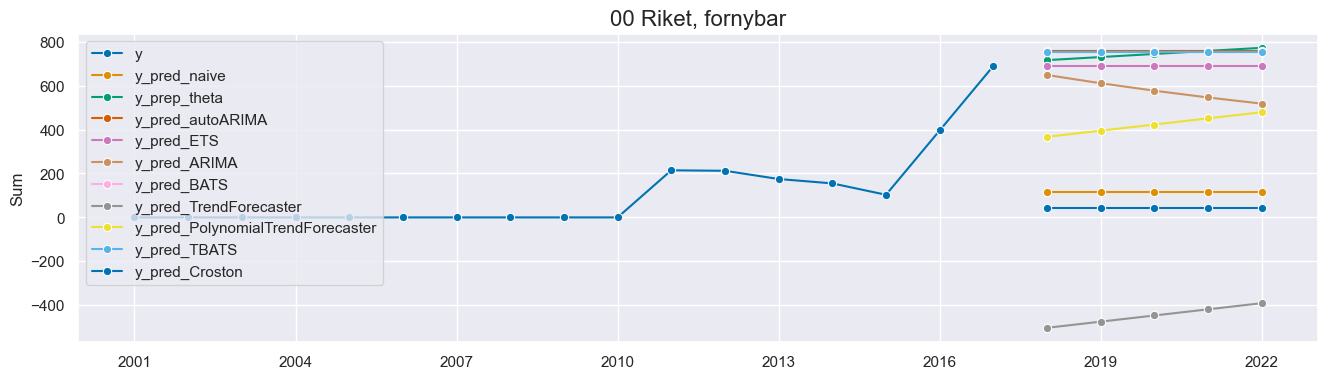

15:41:27 - cmdstanpy - INFO - Chain [1] start processing
15:41:27 - cmdstanpy - INFO - Chain [1] done processing


01 Stockholms l�n
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



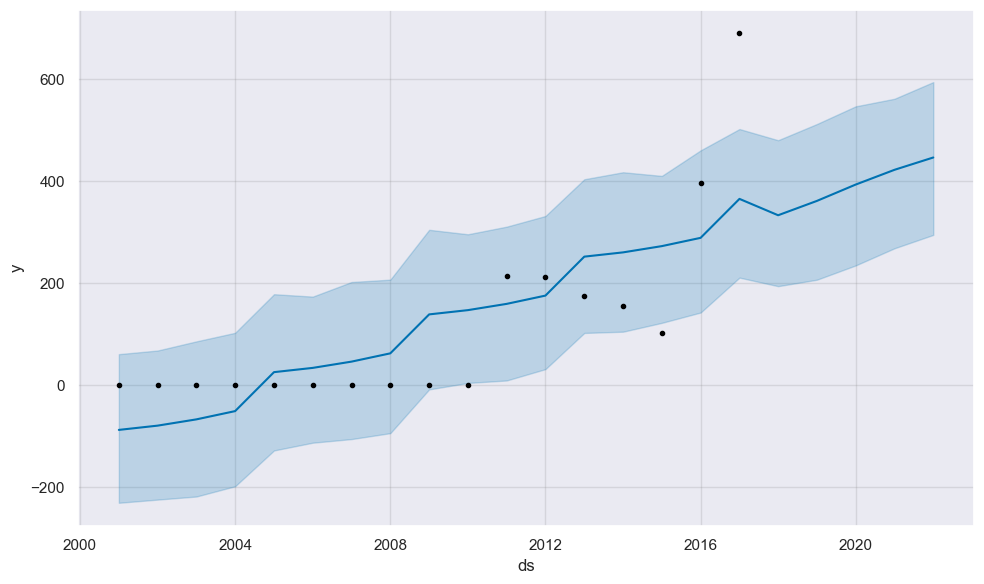

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



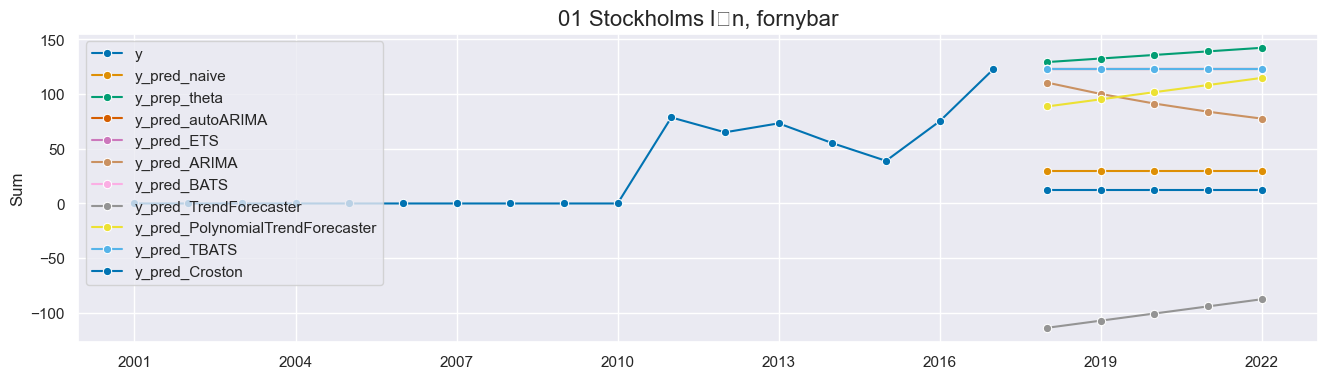

15:41:35 - cmdstanpy - INFO - Chain [1] start processing
15:41:35 - cmdstanpy - INFO - Chain [1] done processing


0117 �ster�ker
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs

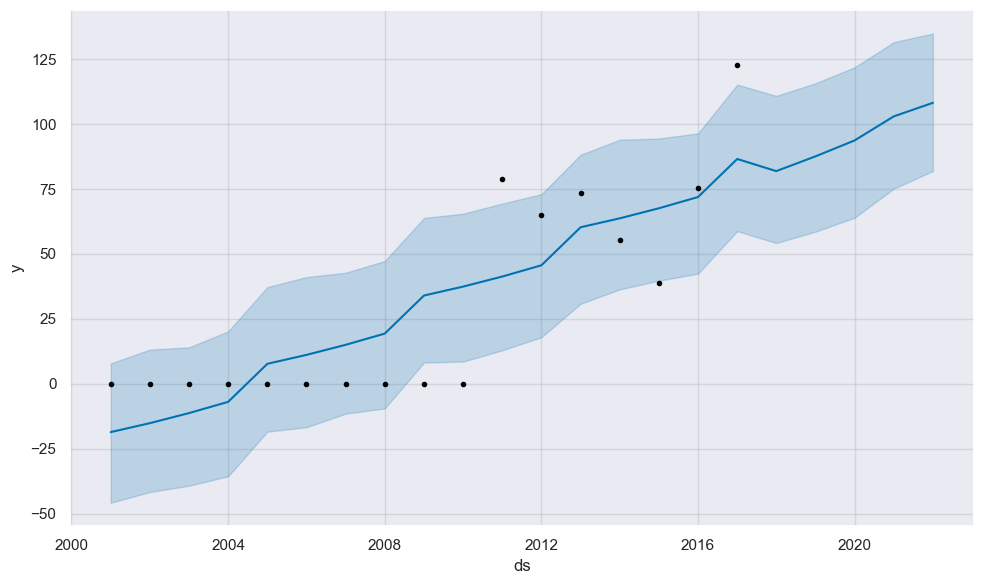

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



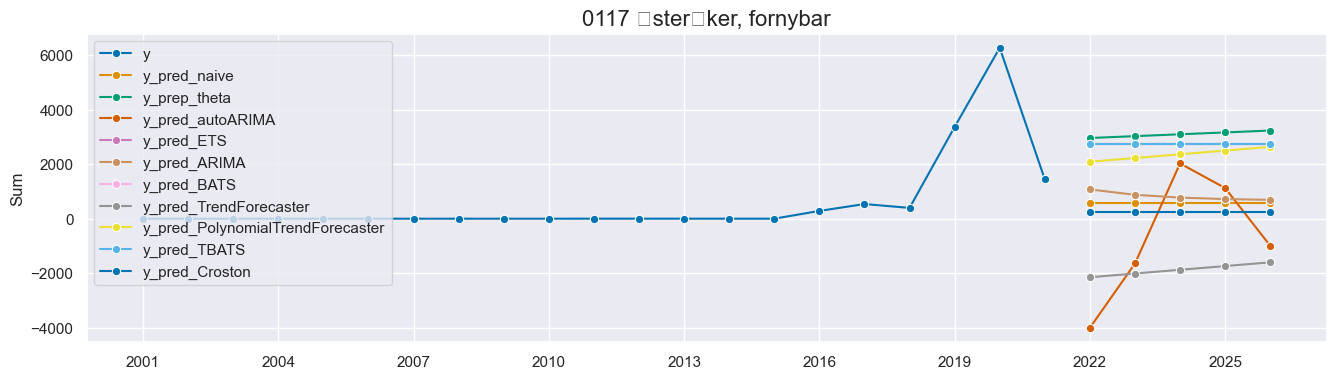

15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing


0160 T�by
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs

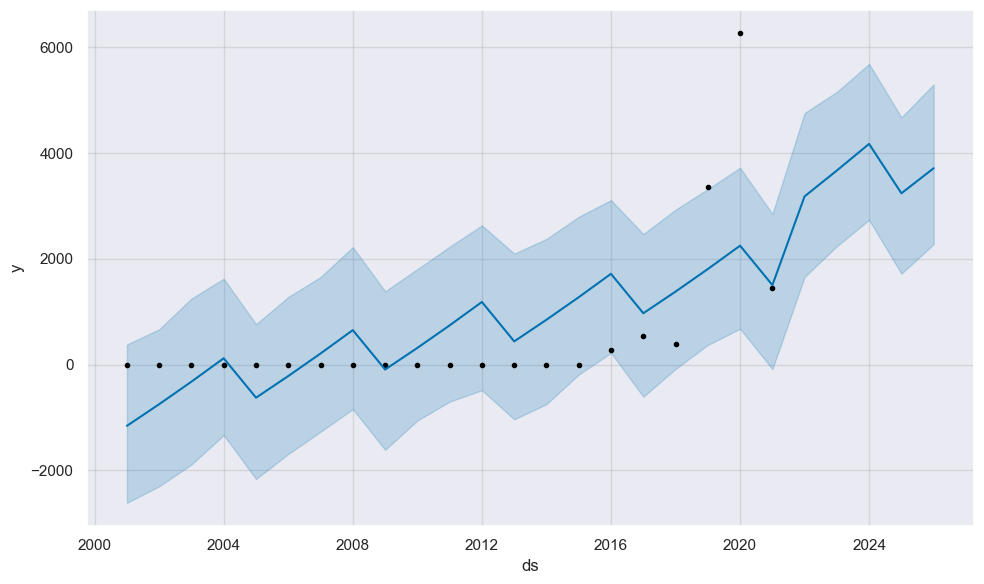

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



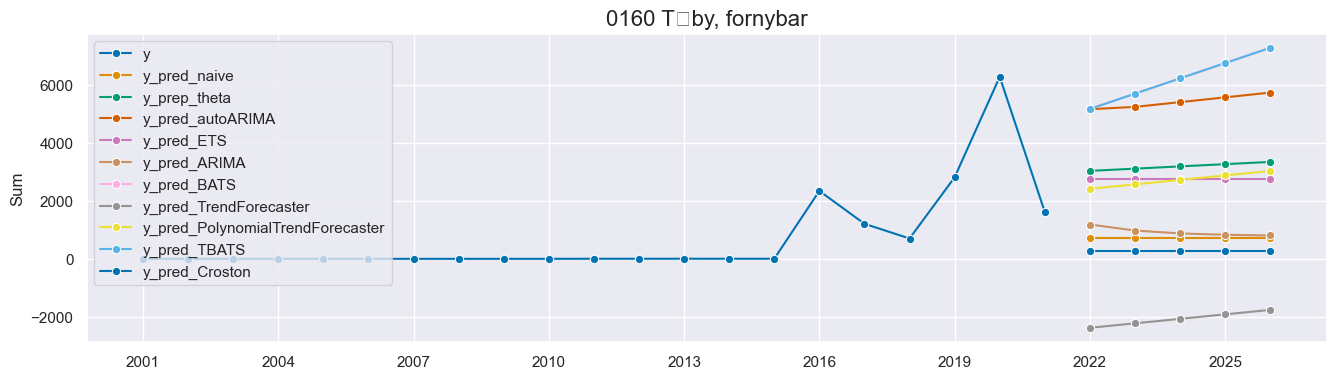

15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing


0180 Stockholm
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



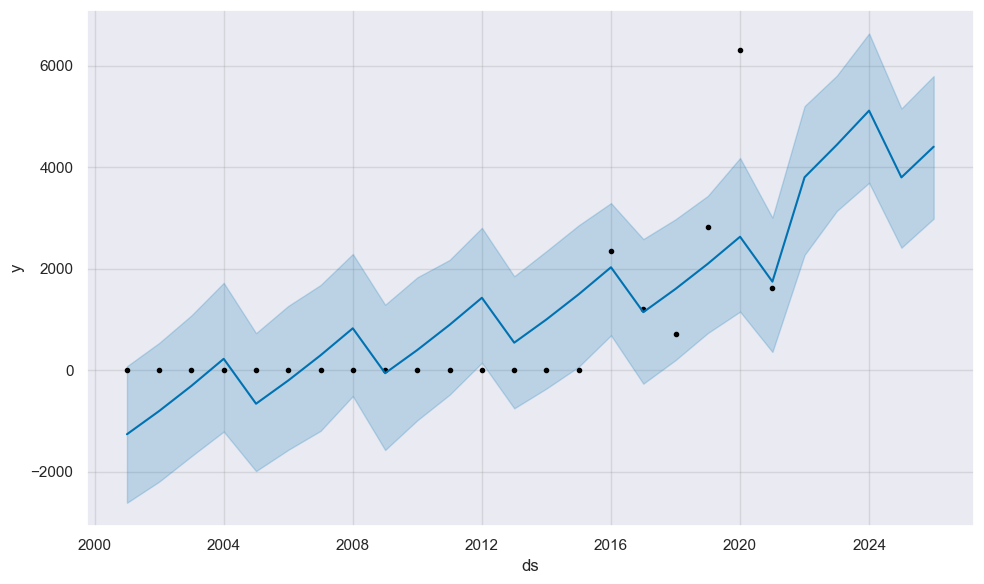

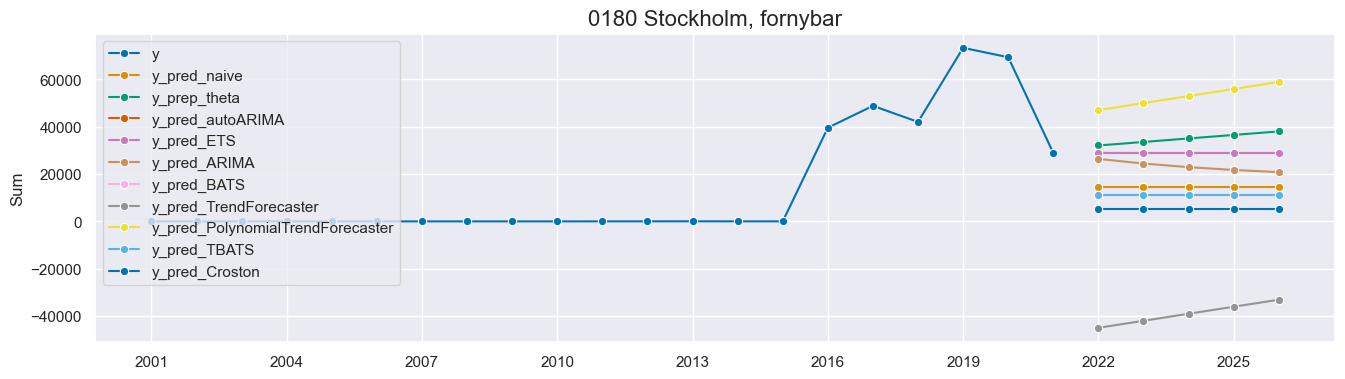

15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing


09 Gotlands l�n
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\

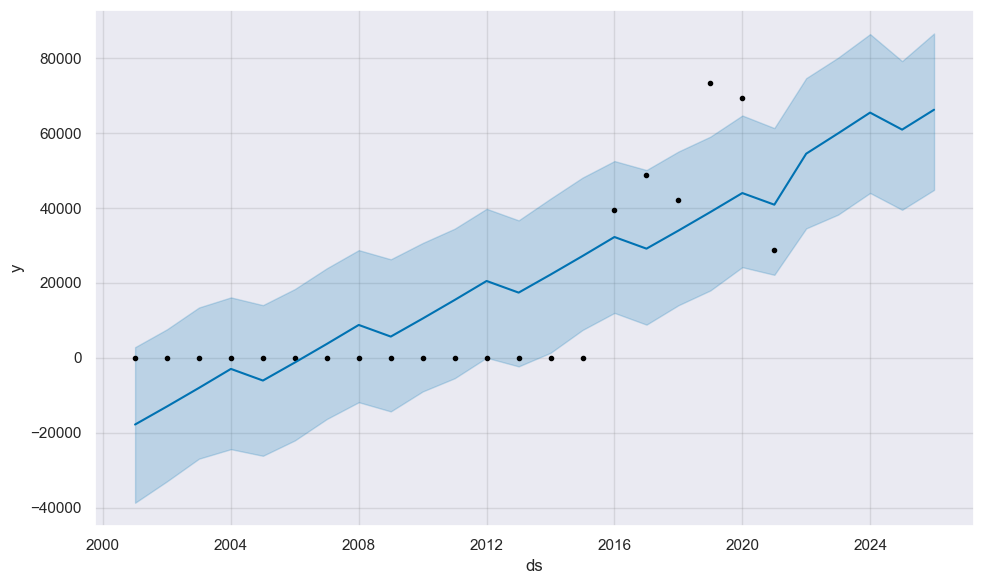

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



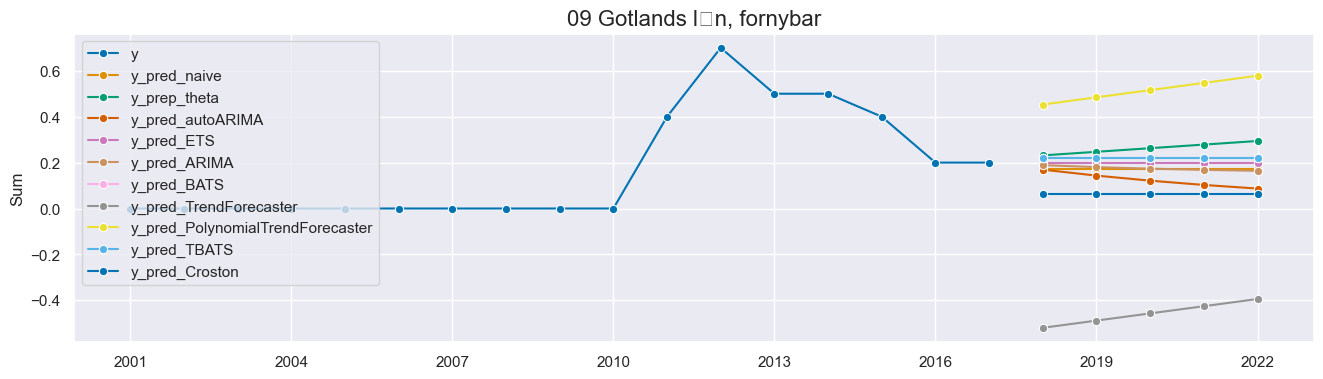

15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing


0980 Gotland
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



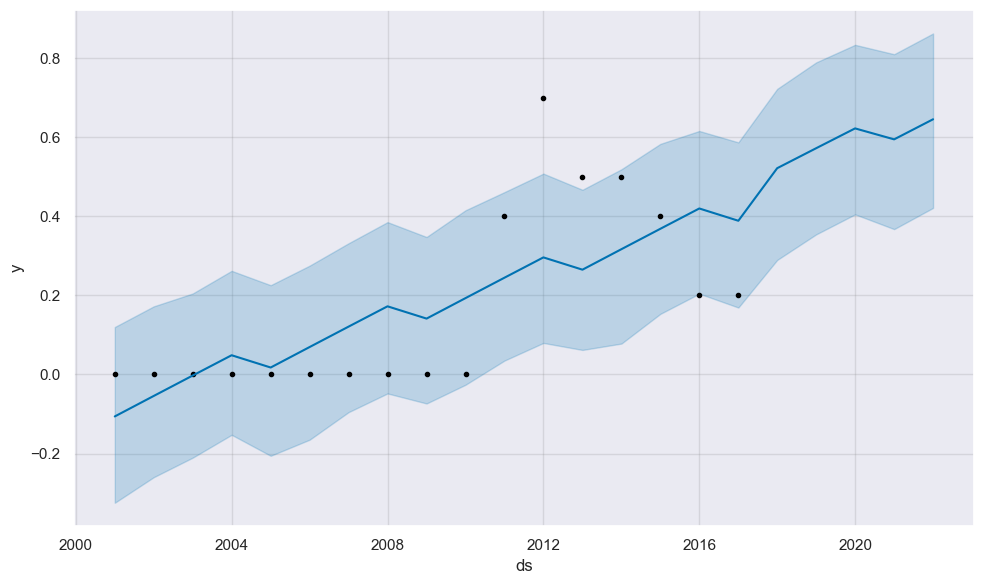

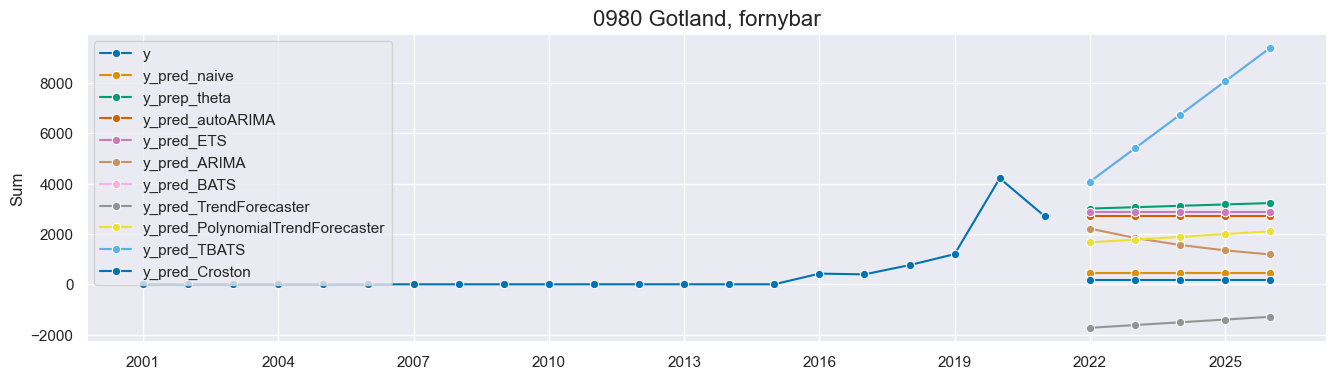

15:42:43 - cmdstanpy - INFO - Chain [1] start processing
15:42:43 - cmdstanpy - INFO - Chain [1] done processing


1480 G�teborg
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



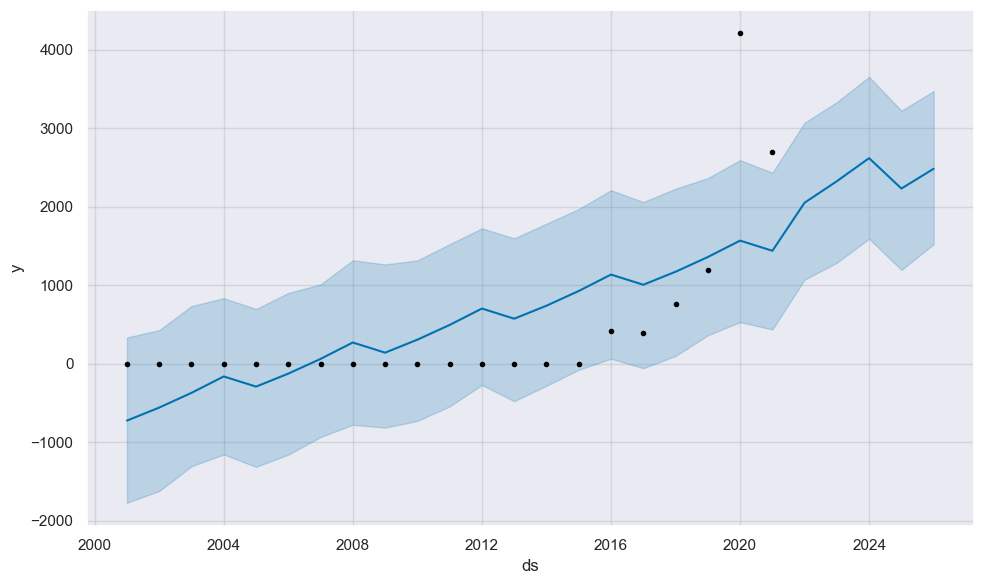

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



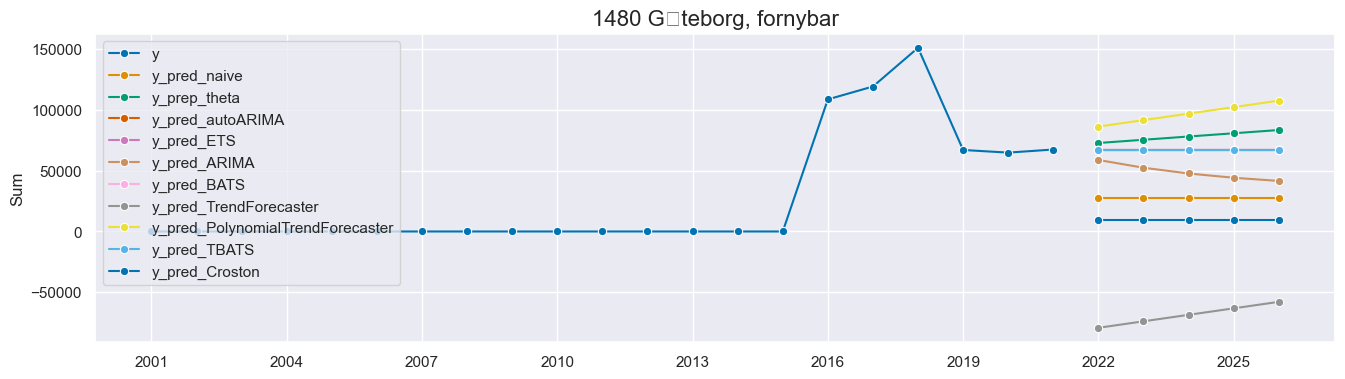

15:42:48 - cmdstanpy - INFO - Chain [1] start processing
15:42:48 - cmdstanpy - INFO - Chain [1] done processing


22 V�sternorrlands l�n
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



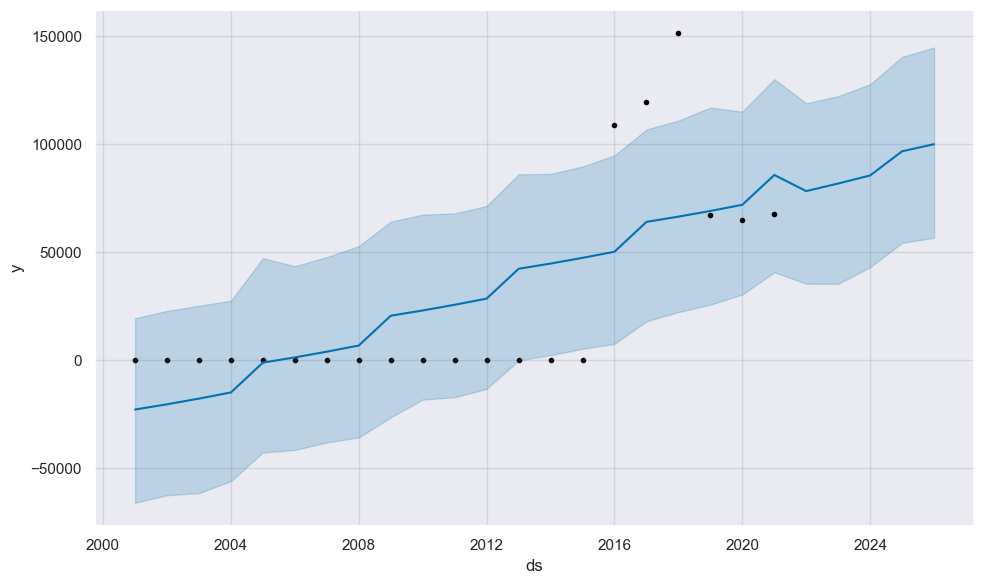

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



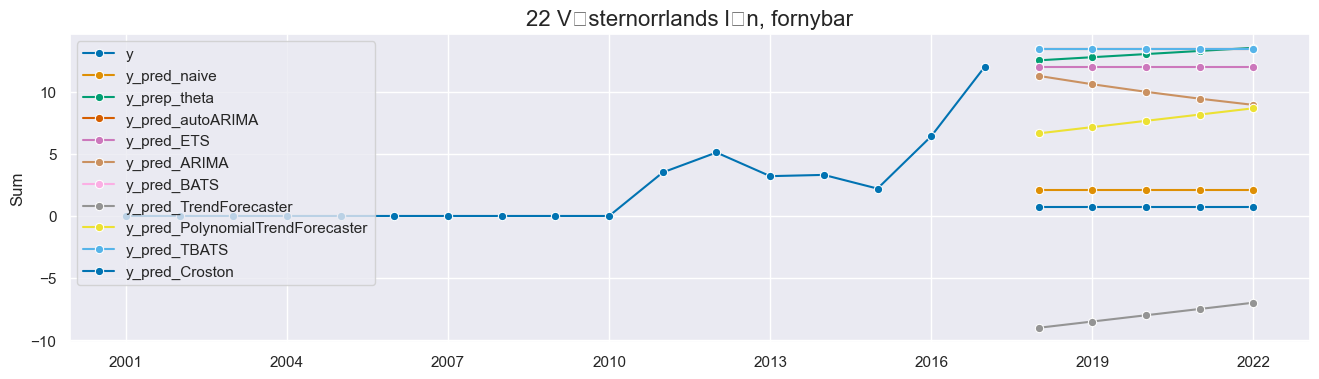

15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] done processing


2581 Pite�
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



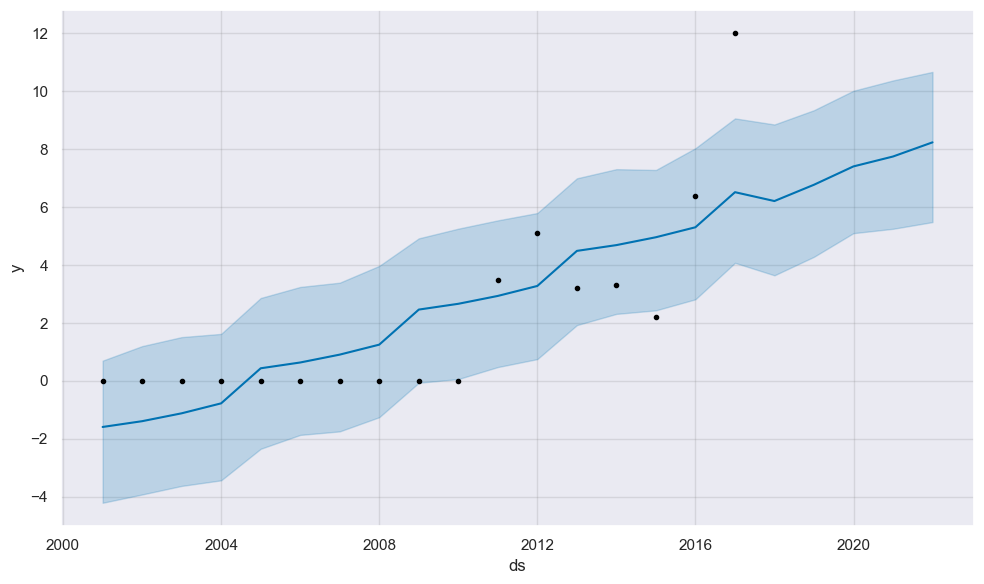

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



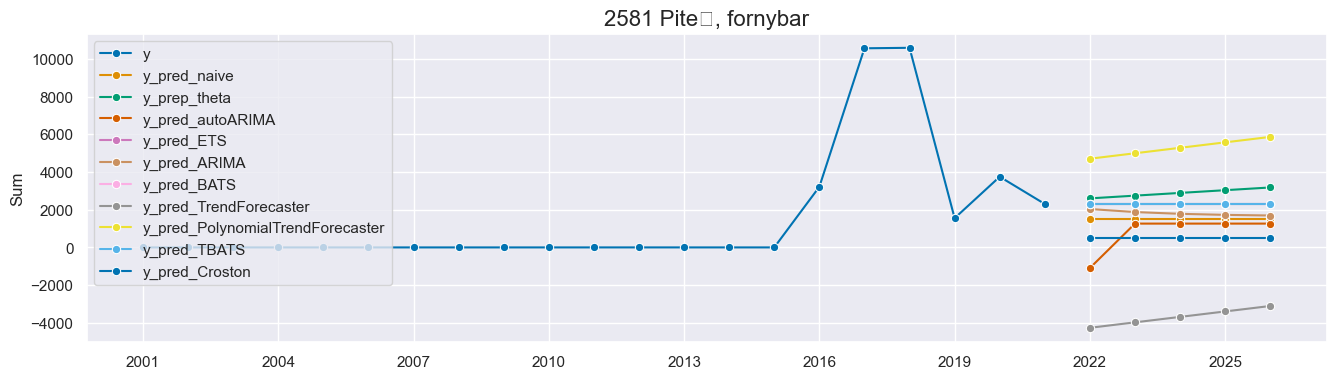

15:43:17 - cmdstanpy - INFO - Chain [1] start processing
15:43:17 - cmdstanpy - INFO - Chain [1] done processing


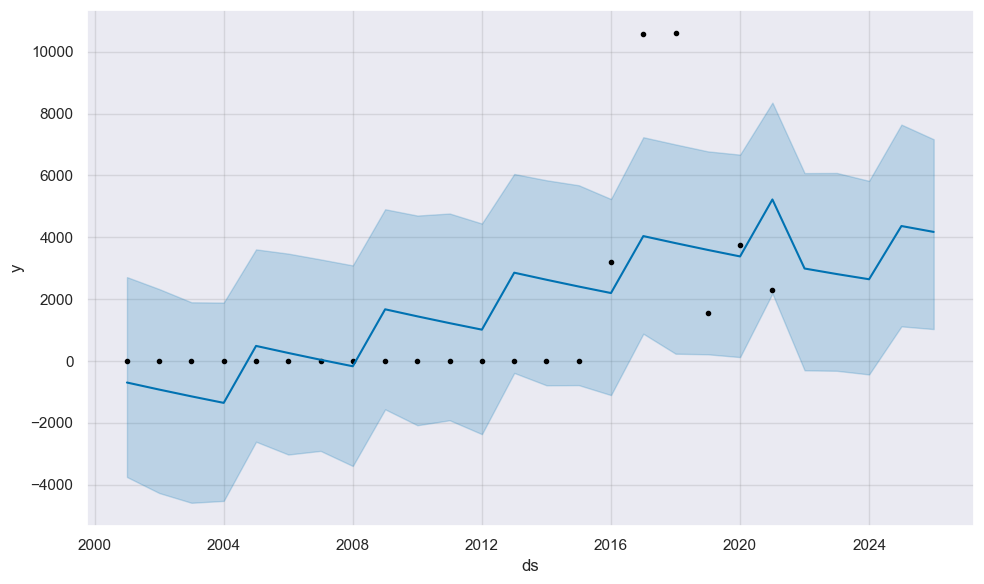

In [95]:
# leveranser_flytande

for region in leveranser_flytande.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = leveranser_flytande[leveranser_flytande.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        
        if not data.empty:
            print(region)
            print(fornybar_bransletyp)
           

            data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
            data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

            y = data[['Sum']].squeeze()
            
            # create forecasting horizon
            fh = ForecastingHorizon(
                    pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
            )
            
            # Instantiate NaiveForecaster:
            forecaster = NaiveForecaster(strategy='mean').fit(y)
            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Instantiate Theta:
            forecaster = ThetaForecaster(deseasonalize=False).fit(y)
            # Predict Thet:
            y_pred_theta = forecaster.predict(fh=fh)
            
            # Instantiate autoARIMA
            forecaster = AutoARIMA(seasonal=False).fit(y)
            # Predict autoARIMA 
            y_pred_autoARIMA = forecaster.predict(fh)

            # Instantiate AutoETS
            forecaster = AutoETS().fit(y)
            # Predict AutoETS 
            y_pred_ETS = forecaster.predict(fh)

            # Instantiate ARIMA
            forecaster = ARIMA().fit(y)
            # Predict ARIMA 
            y_pred_ARIMA = forecaster.predict(fh)

            # Instantiate BATS
            forecaster = BATS().fit(y)
            # Predict BATS 
            y_pred_BATS = forecaster.predict(fh)

            # Instantiate TrendForecaster
            forecaster = TrendForecaster().fit(y)
            # Predict TrendForecaster 
            y_pred_TrendForecaster = forecaster.predict(fh)

            # Instantiate PolynomialTrendForecaster
            forecaster = PolynomialTrendForecaster().fit(y)
            # Predict PolynomialTrendForecaster 
            y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
            
            # Instantiate TBATS
            forecaster = TBATS().fit(y)
            # Predict TBATS 
            y_pred_TBATS = forecaster.predict(fh)
            
            # Instantiate Croston
            forecaster = Croston().fit(y)
            # Predict Croston 
            y_pred_Croston = forecaster.predict(fh)
            
            # Check it out:
            fig = plot_series(y, y_pred, y_pred_theta, y_pred_autoARIMA, y_pred_ETS, y_pred_ARIMA, y_pred_BATS, y_pred_TrendForecaster, y_pred_PolynomialTrendForecaster, y_pred_TBATS, y_pred_Croston, 
                                labels=["y", "y_pred_naive", "y_prep_theta", "y_pred_autoARIMA", "y_pred_ETS", "y_pred_ARIMA", "y_pred_BATS", "y_pred_TrendForecaster", "y_pred_PolynomialTrendForecaster", "y_pred_TBATS", "y_pred_Croston"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig)


            # # Prophet
            data['ds'] = data.index.to_timestamp()
            data['y'] = data.Sum
            m = Prophet(
                yearly_seasonality=True,)
            m.fit(data)
            future = m.make_future_dataframe(
                periods=5, 
                freq='Y',
                )
            forecast = m.predict(future)
            fig1 = m.plot(forecast)
            plot_plotly(m, forecast)


            # print("----------------")   

        # else:
        #     print("----------------")   




00 Riket
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



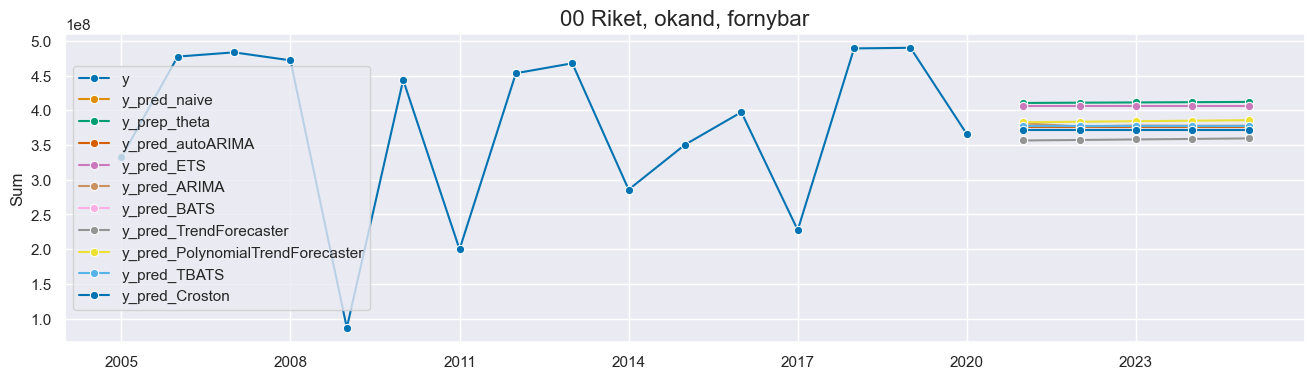

15:58:39 - cmdstanpy - INFO - Chain [1] start processing
15:58:39 - cmdstanpy - INFO - Chain [1] done processing


01 Stockholms l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



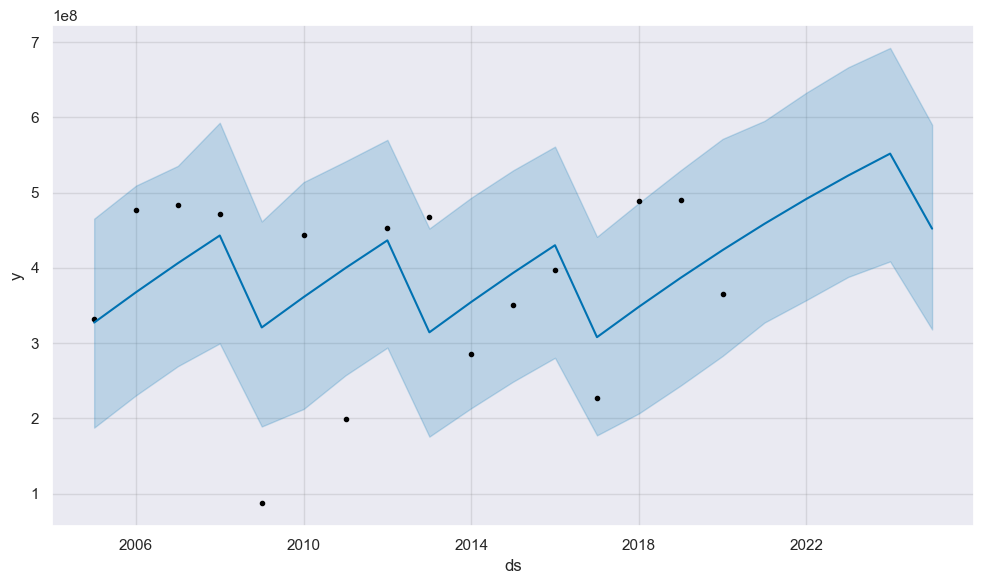

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



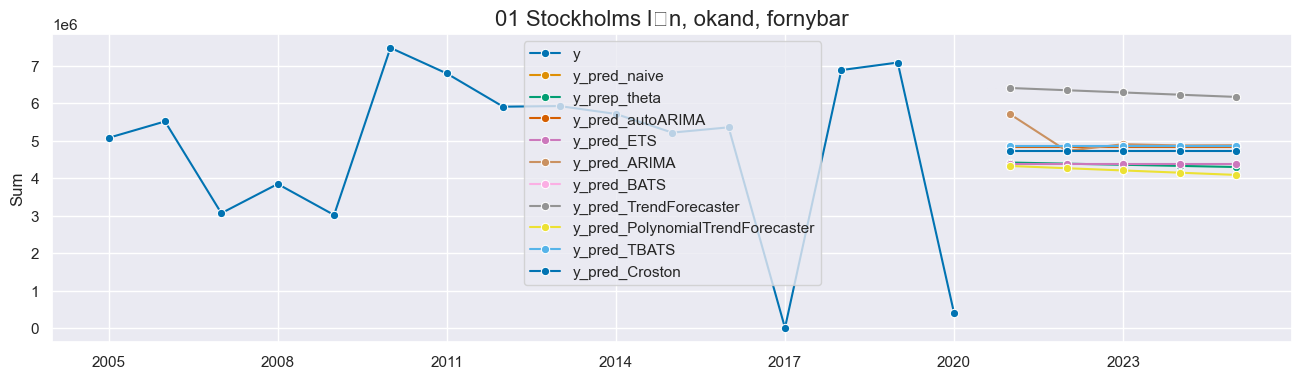

15:58:50 - cmdstanpy - INFO - Chain [1] start processing
15:58:50 - cmdstanpy - INFO - Chain [1] done processing


0117 �ster�ker
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\exponential_smoothing\ets.py:1161: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\scipy\optimi

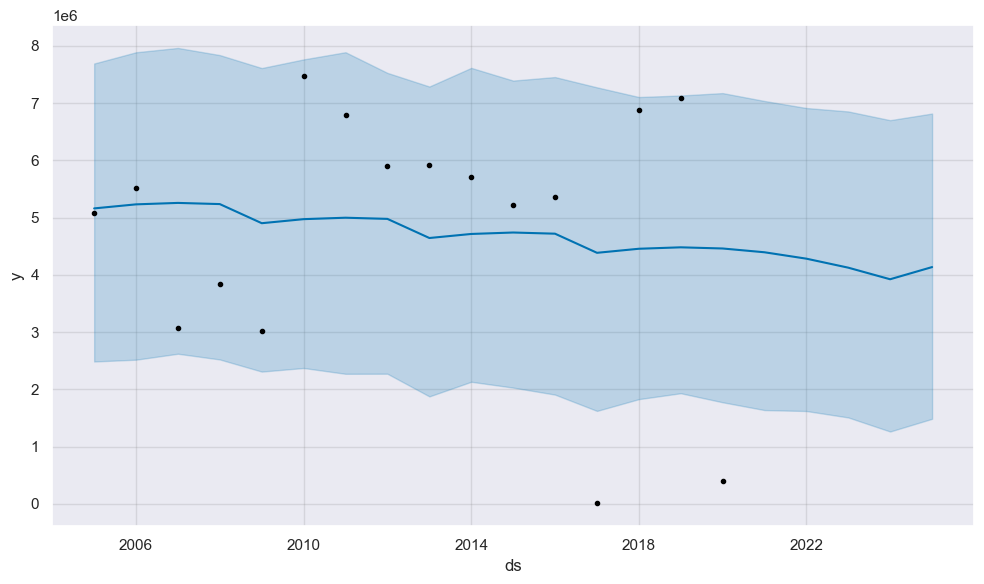

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



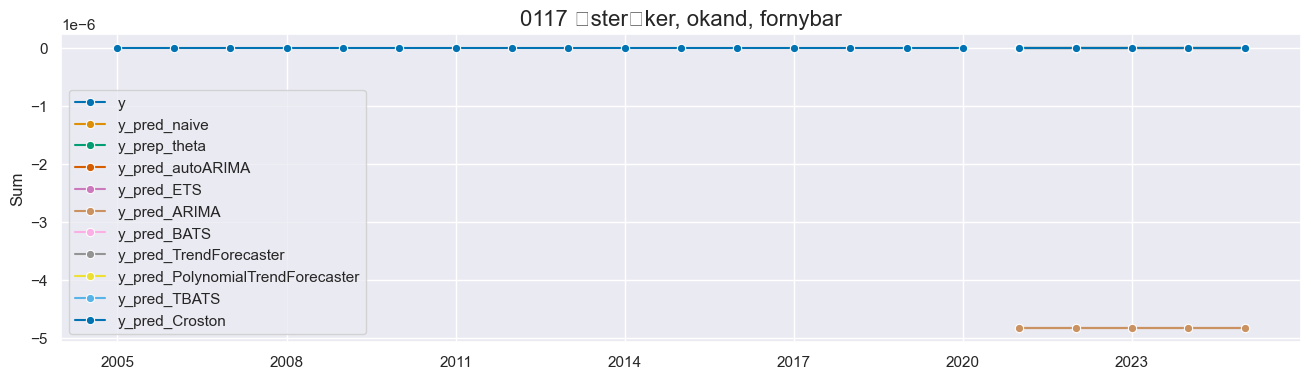

0160 T�by
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\exponential_smoothing\ets.py:1161: RuntimeWarning:

divide by zero encountered in log

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\scipy\optimi

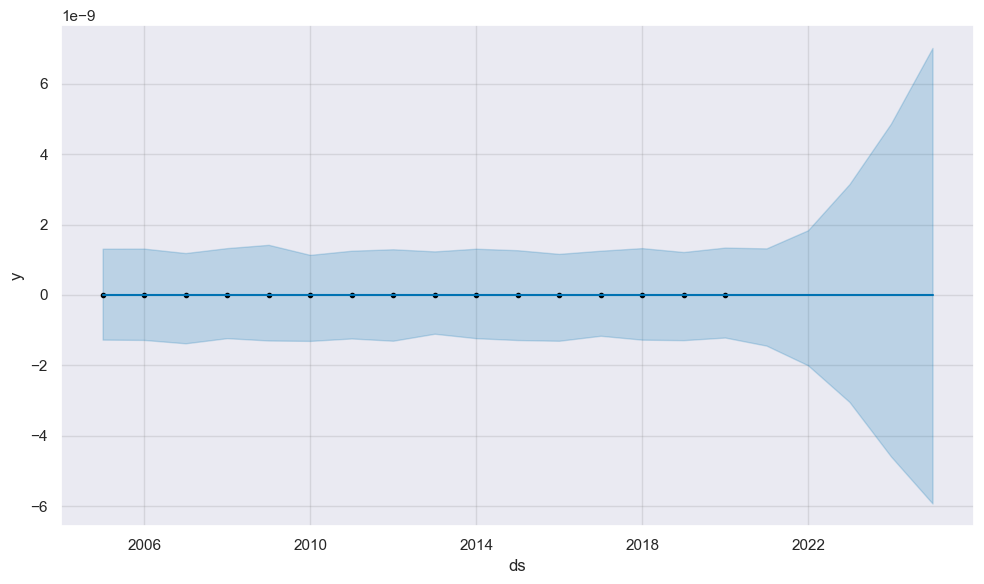

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



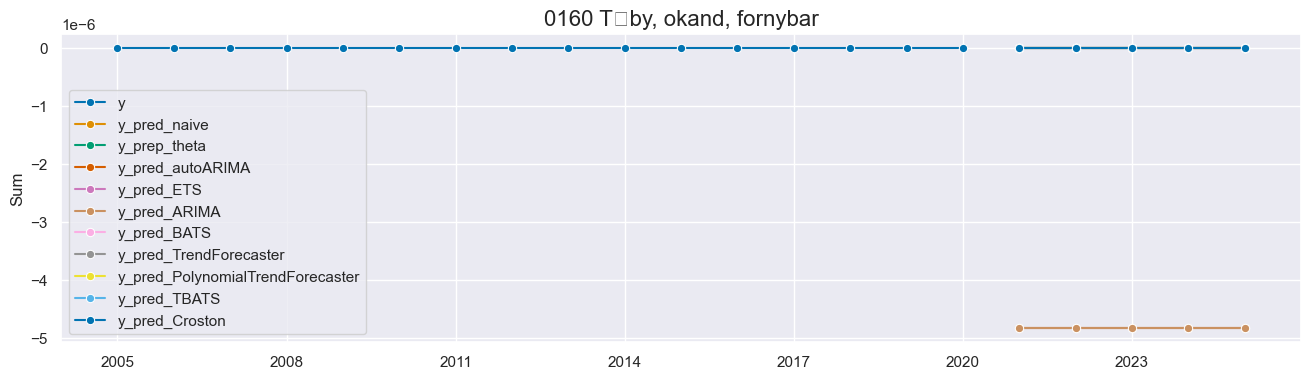

0180 Stockholm
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



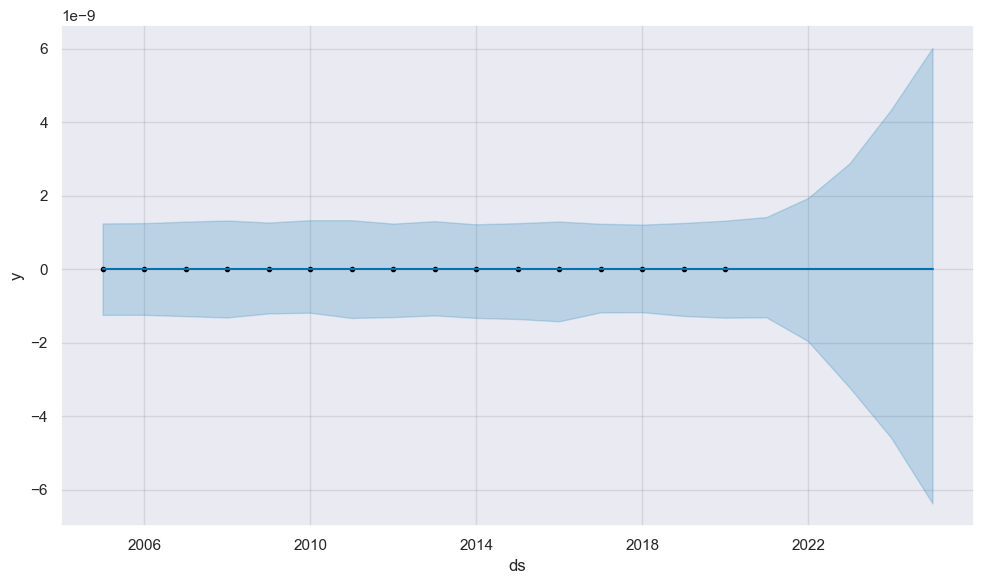

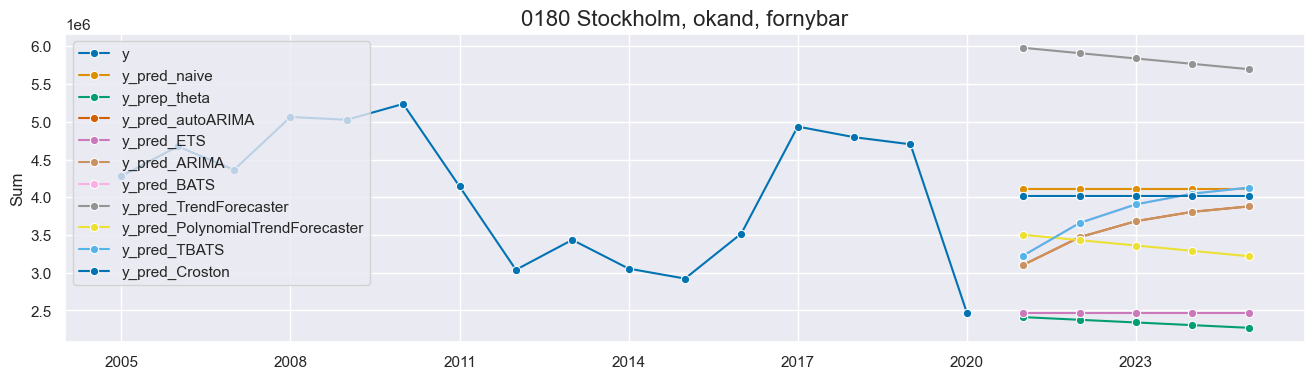

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing


09 Gotlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



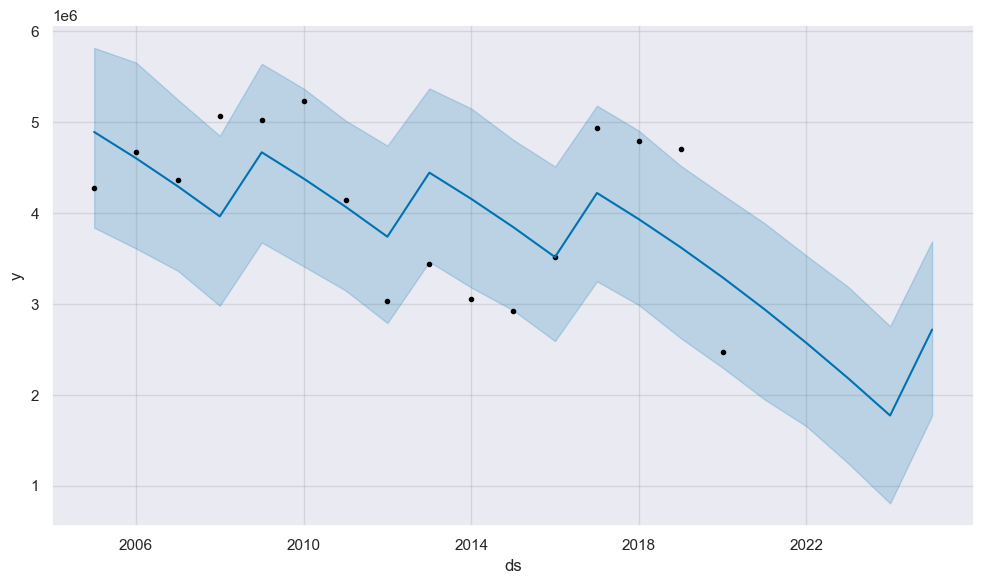

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



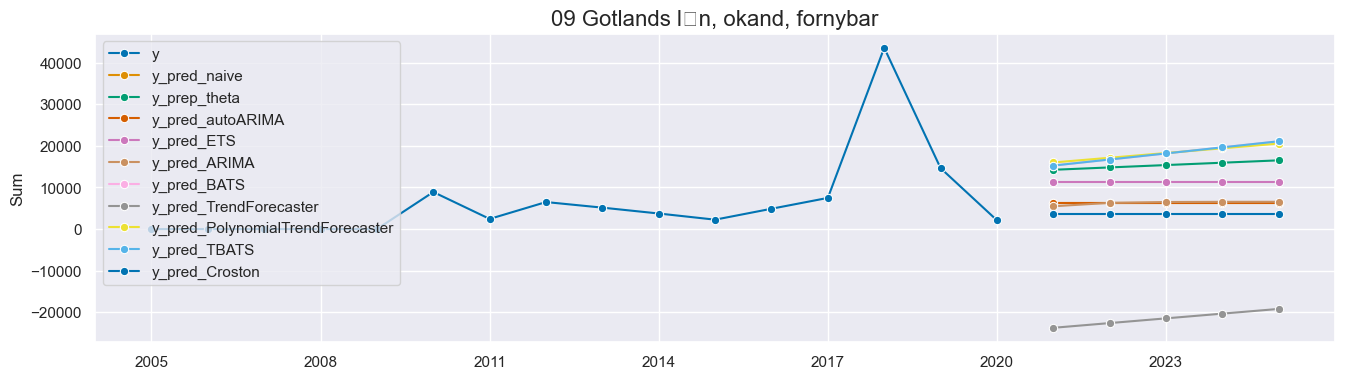

15:59:43 - cmdstanpy - INFO - Chain [1] start processing
15:59:43 - cmdstanpy - INFO - Chain [1] done processing


0980 Gotland
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



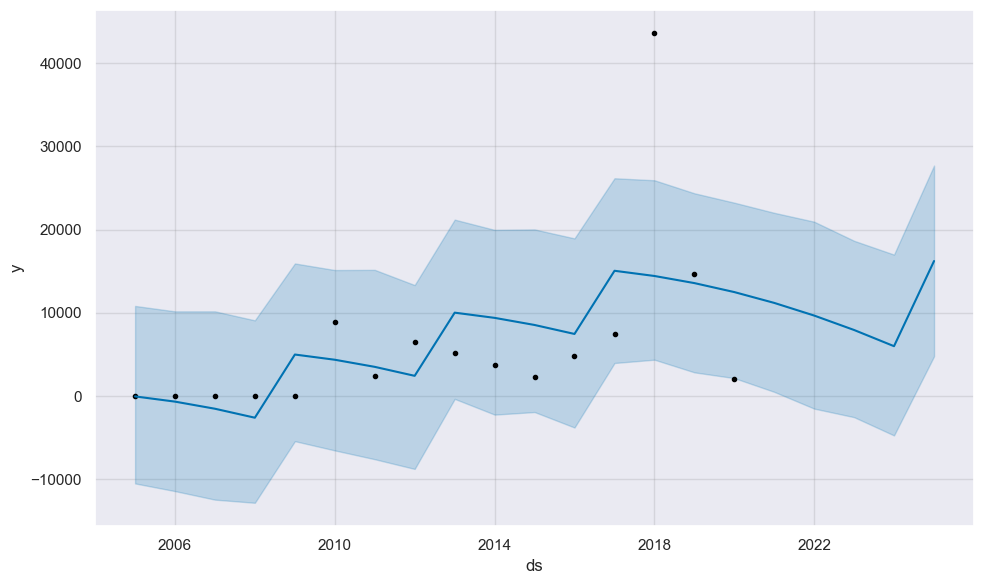

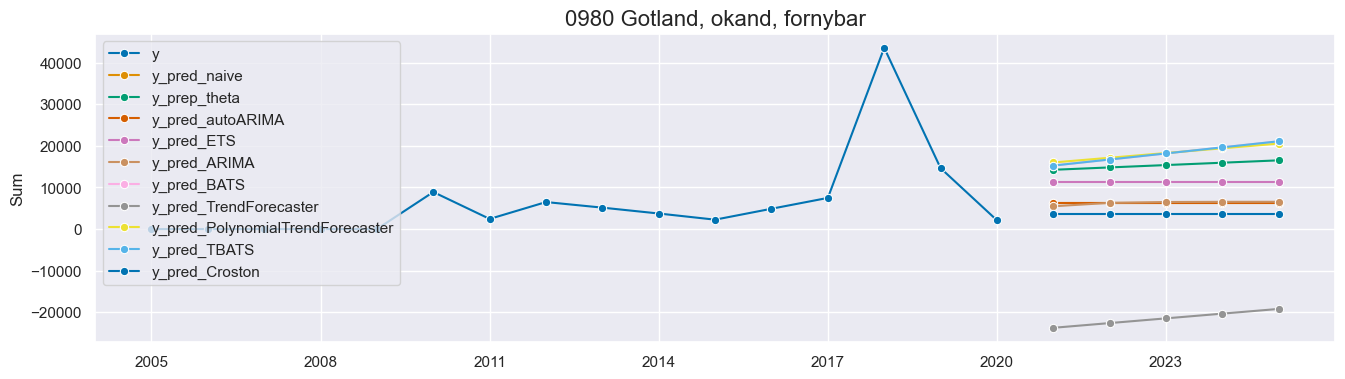

15:59:48 - cmdstanpy - INFO - Chain [1] start processing
15:59:49 - cmdstanpy - INFO - Chain [1] done processing


1480 G�teborg
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



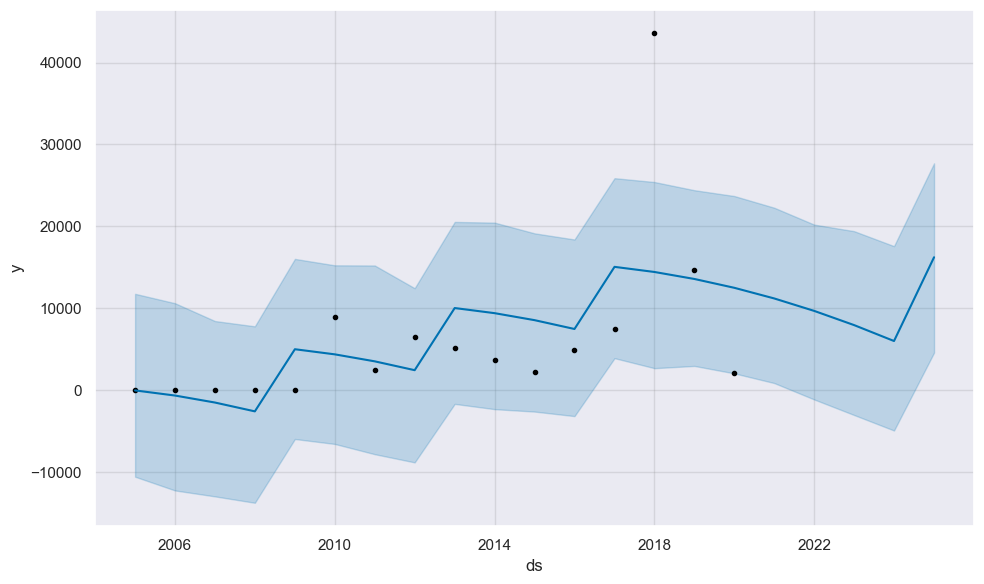

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



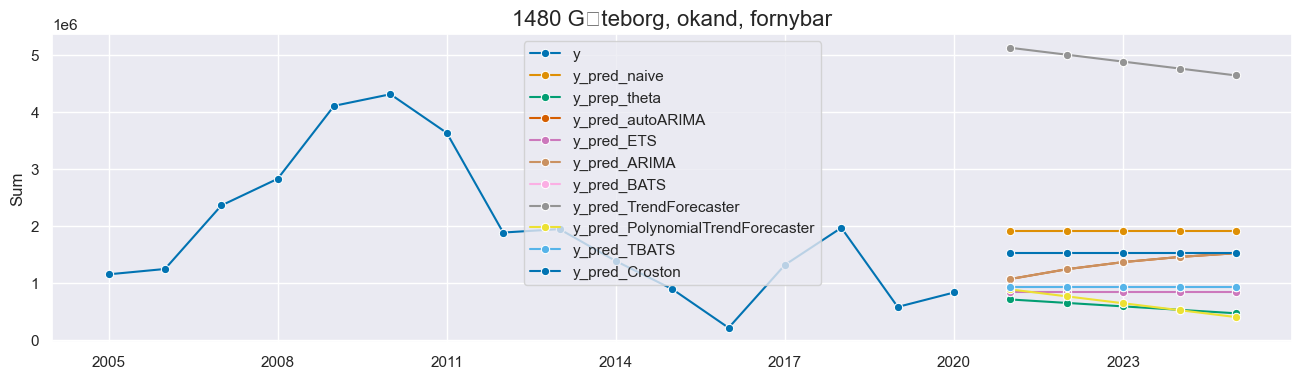

16:00:25 - cmdstanpy - INFO - Chain [1] start processing
16:00:25 - cmdstanpy - INFO - Chain [1] done processing


22 V�sternorrlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



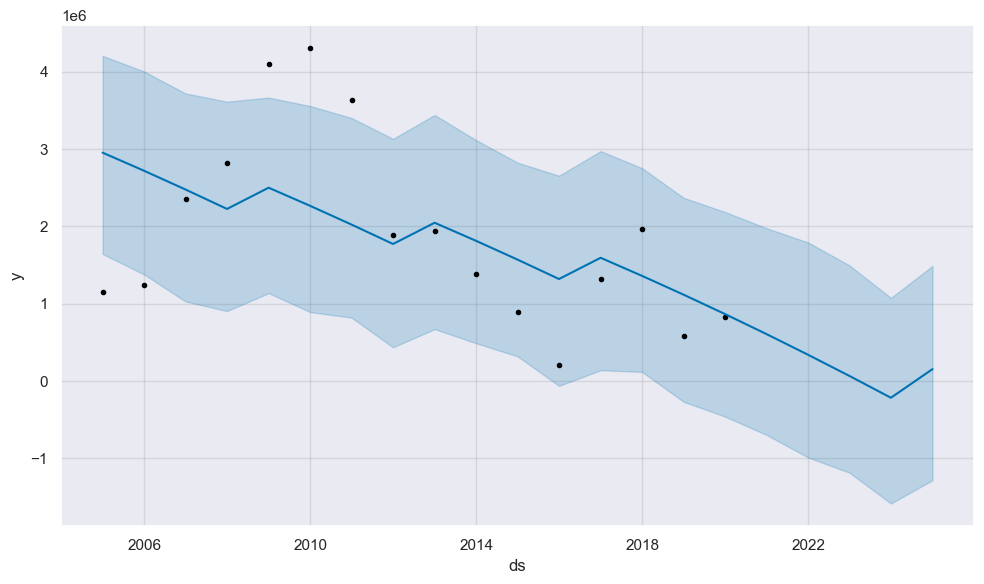

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



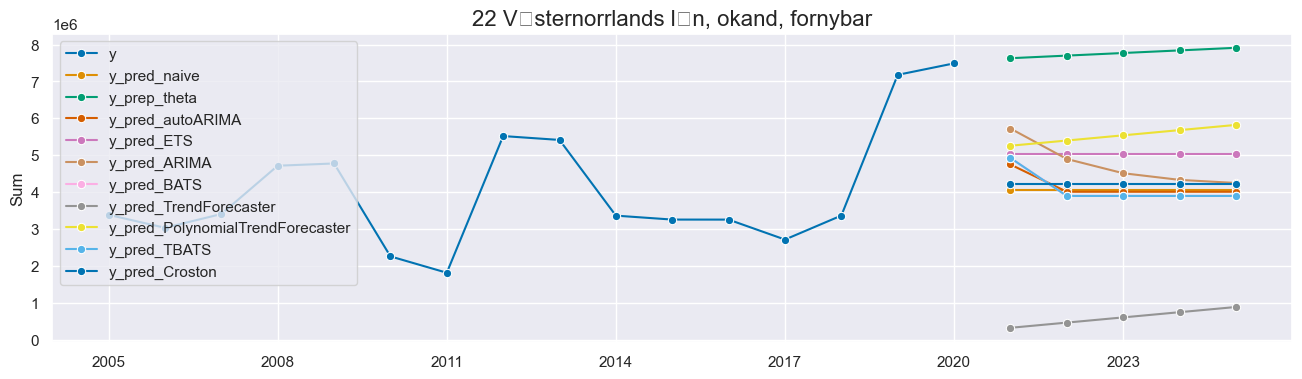

16:00:44 - cmdstanpy - INFO - Chain [1] start processing
16:00:45 - cmdstanpy - INFO - Chain [1] done processing


2581 Pite�
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



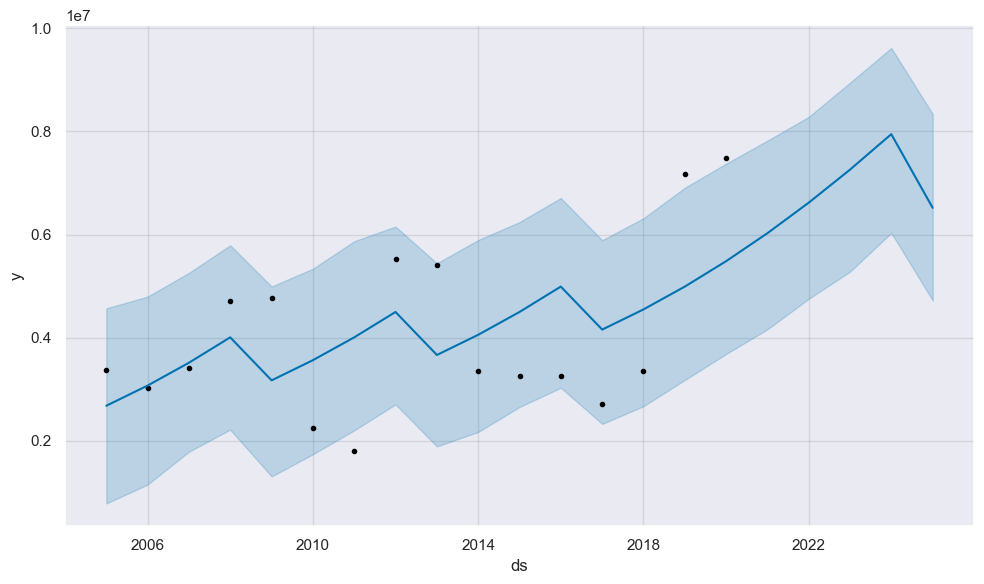

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



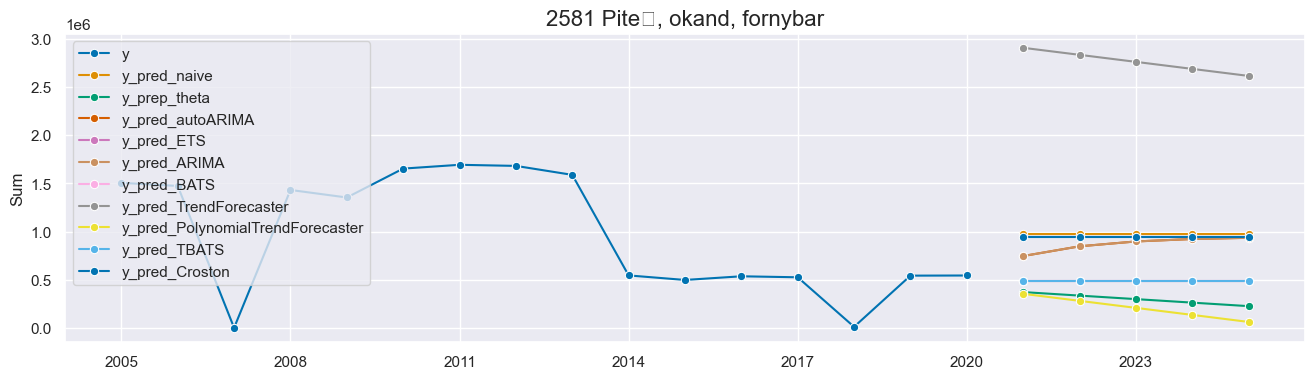

16:00:52 - cmdstanpy - INFO - Chain [1] start processing
16:00:52 - cmdstanpy - INFO - Chain [1] done processing


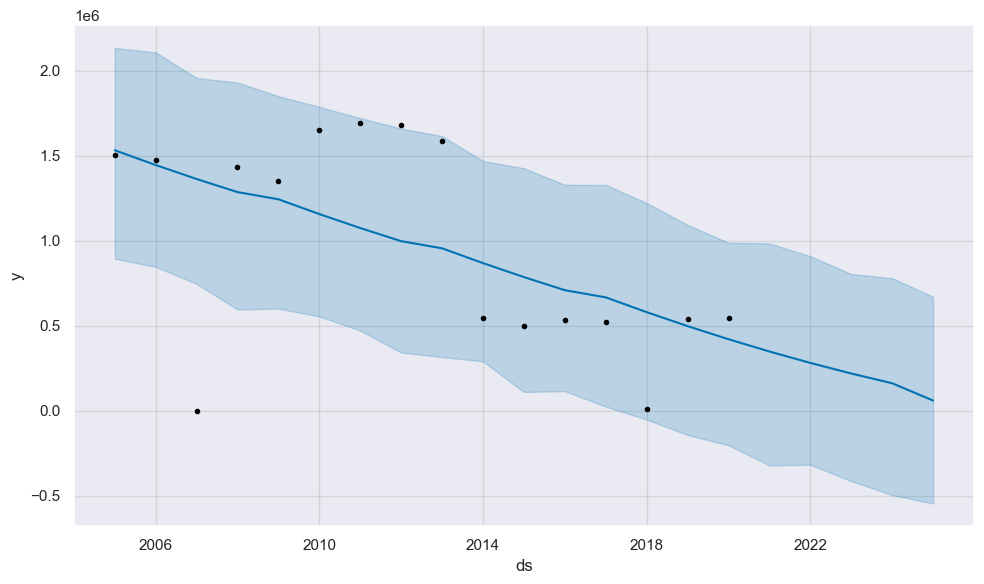

In [96]:
# elproduction_bransleanvandning_grouped
for region in elproduction_bransleanvandning_grouped.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = elproduction_bransleanvandning_grouped[elproduction_bransleanvandning_grouped.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(fornybar_produktionssatt)
                
                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS().fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA().fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS().fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # Instantiate PolynomialTrendForecaster
                forecaster = PolynomialTrendForecaster().fit(y)
                # Predict PolynomialTrendForecaster 
                y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS().fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, y_pred_theta, y_pred_autoARIMA, y_pred_ETS, y_pred_ARIMA, y_pred_BATS, y_pred_TrendForecaster, y_pred_PolynomialTrendForecaster, y_pred_TBATS, y_pred_Croston, 
                                    labels=["y", "y_pred_naive", "y_prep_theta", "y_pred_autoARIMA", "y_pred_ETS", "y_pred_ARIMA", "y_pred_BATS", "y_pred_TrendForecaster", "y_pred_PolynomialTrendForecaster", "y_pred_TBATS", "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, fornybar_produktionssatt), fontsize=16)
                plt.show(fig)            
                
                
                # # Prophet
                data['ds'] = data.index.to_timestamp()
                data['y'] = data.Sum
                m = Prophet(
                    yearly_seasonality=True,)
                m.fit(data)
                future = m.make_future_dataframe(
                    periods=5, 
                    freq='Y',
                    )
                forecast = m.predict(future)
                fig1 = m.plot(forecast)
                plot_plotly(m, forecast)

                # print("----------------")   

            # else:
            #     print("----------------")   






00 Riket
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



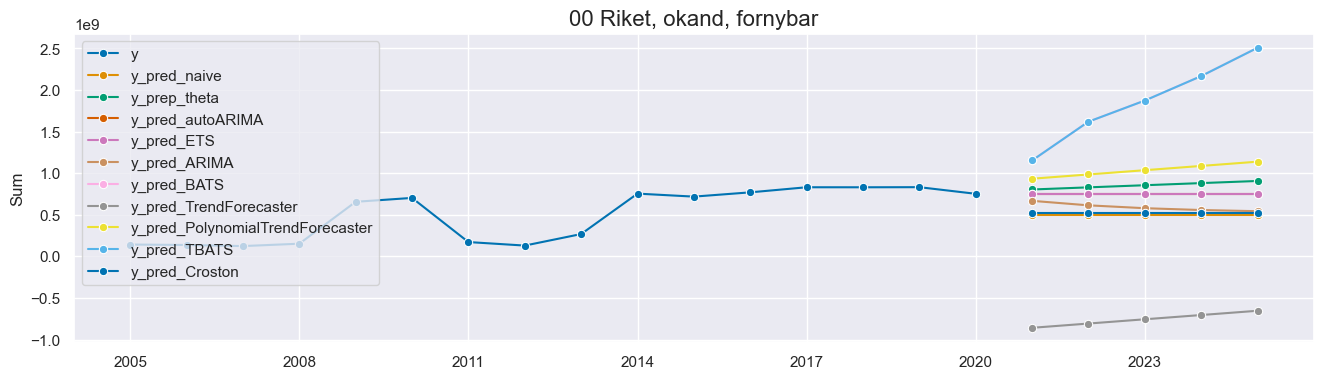

16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing


01 Stockholms l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



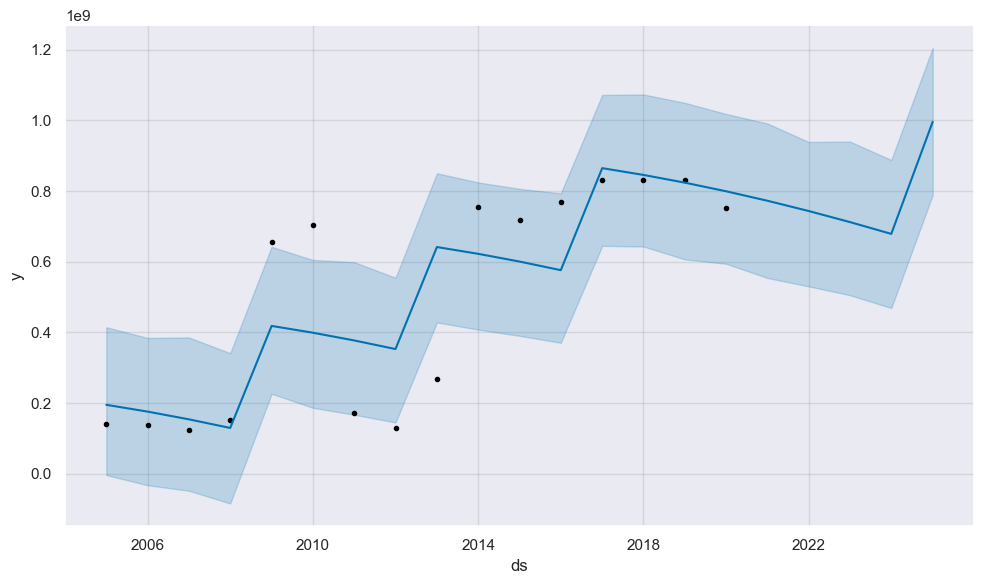

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



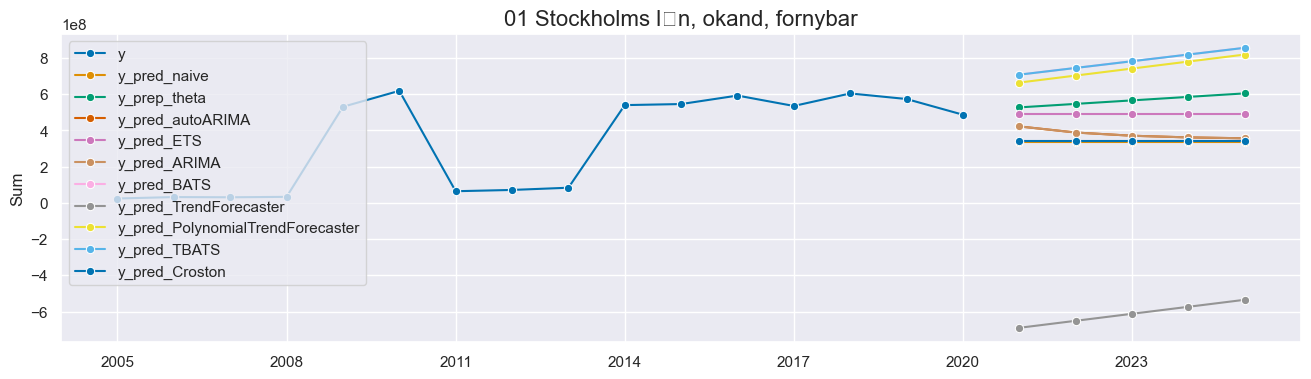

16:02:32 - cmdstanpy - INFO - Chain [1] start processing
16:02:32 - cmdstanpy - INFO - Chain [1] done processing


0117 �ster�ker
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



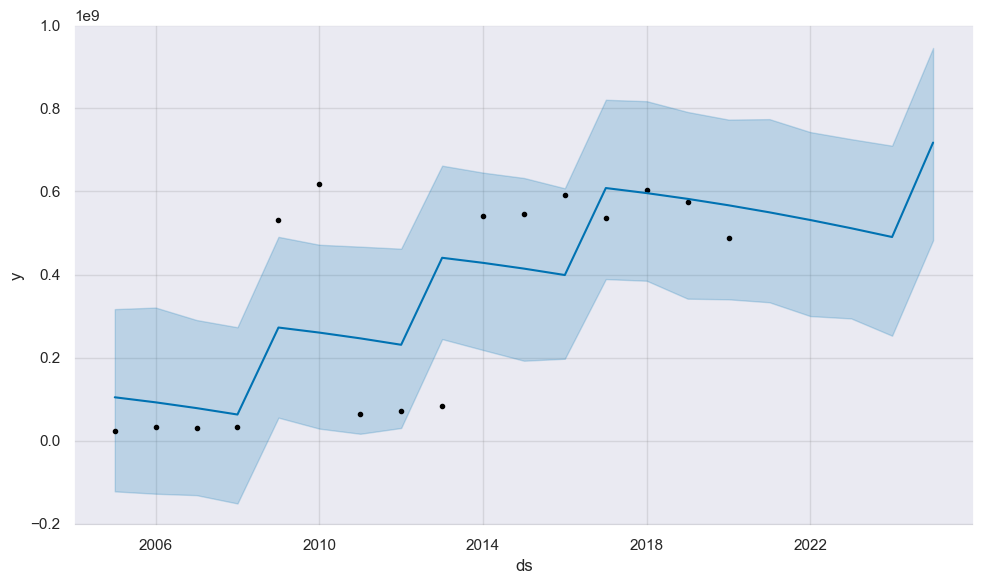

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



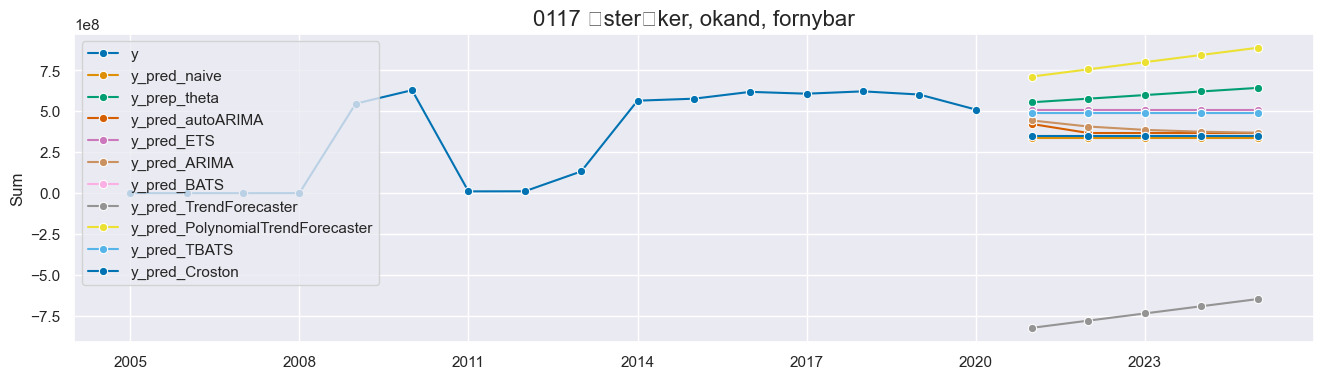

16:03:05 - cmdstanpy - INFO - Chain [1] start processing
16:03:05 - cmdstanpy - INFO - Chain [1] done processing


0160 T�by
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



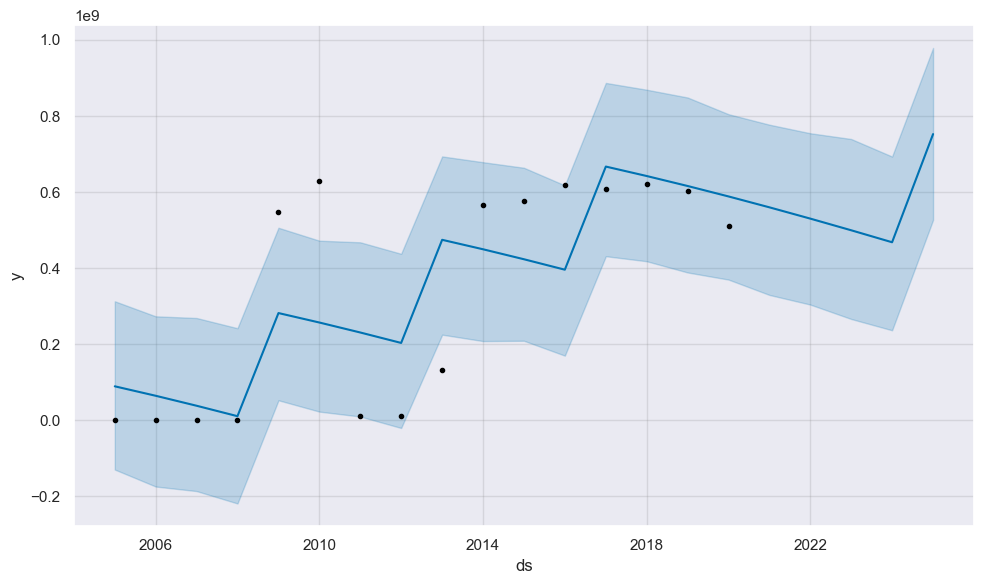

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



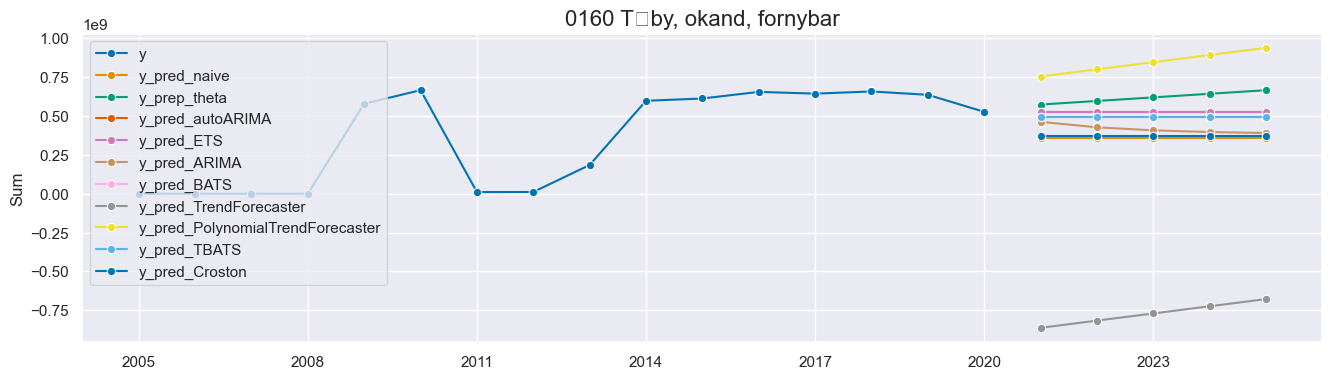

16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing


0180 Stockholm
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



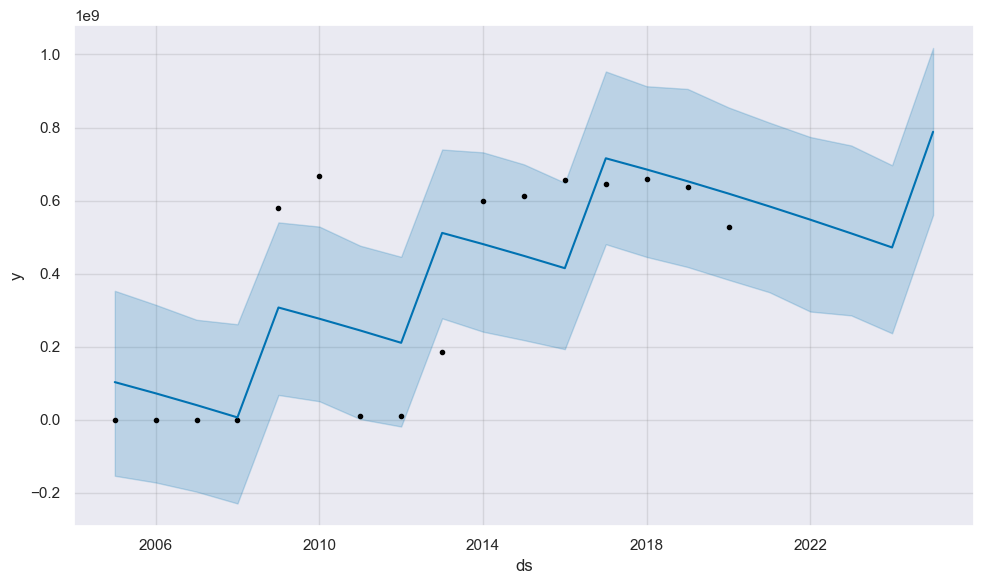

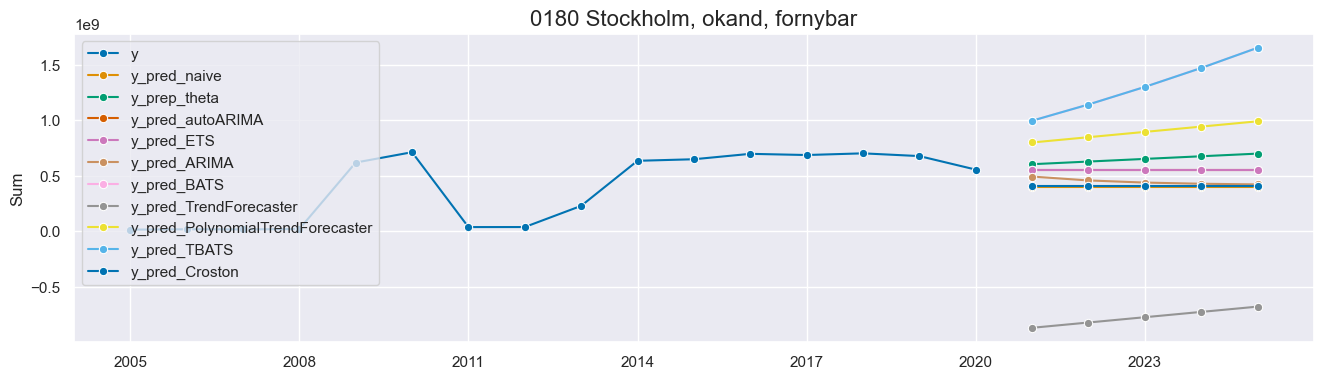

16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing


09 Gotlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



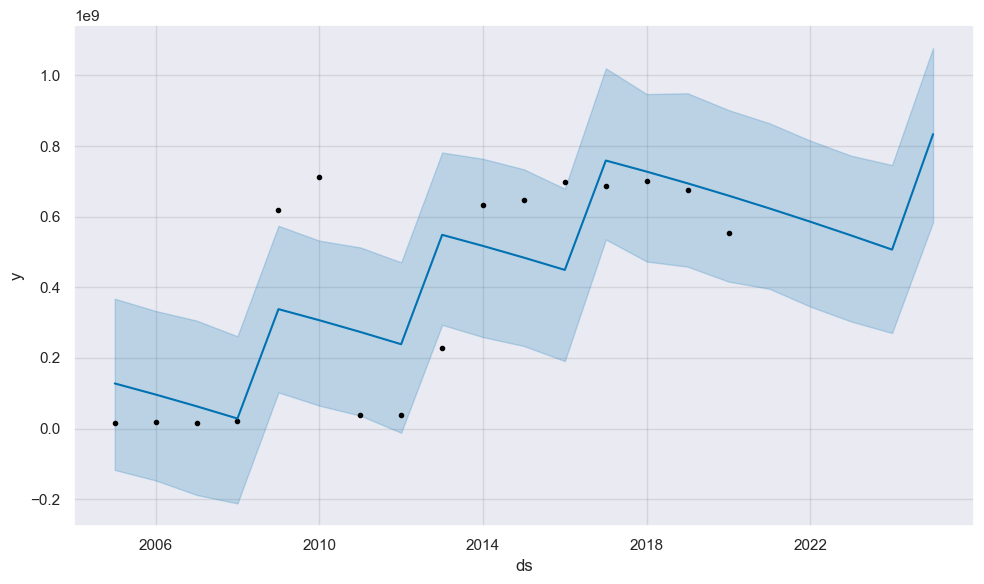

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



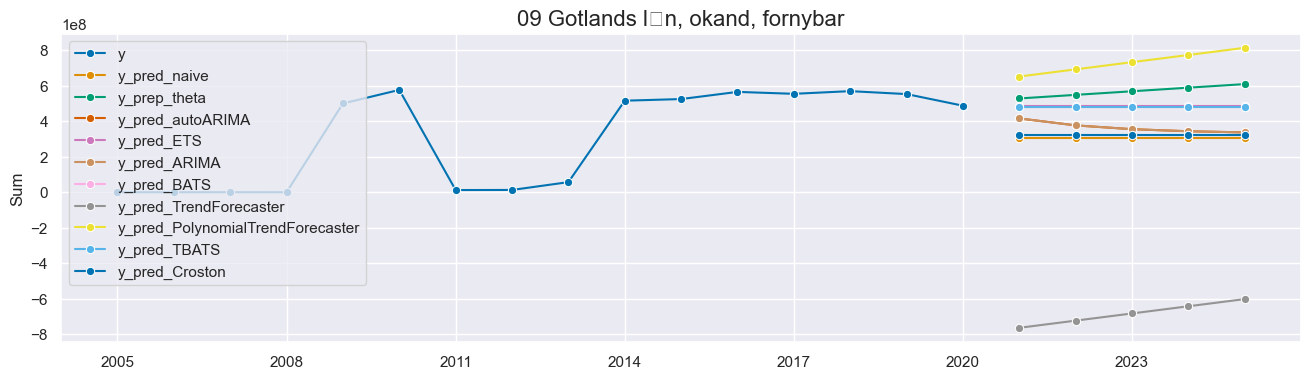

16:03:53 - cmdstanpy - INFO - Chain [1] start processing
16:03:53 - cmdstanpy - INFO - Chain [1] done processing


0980 Gotland
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



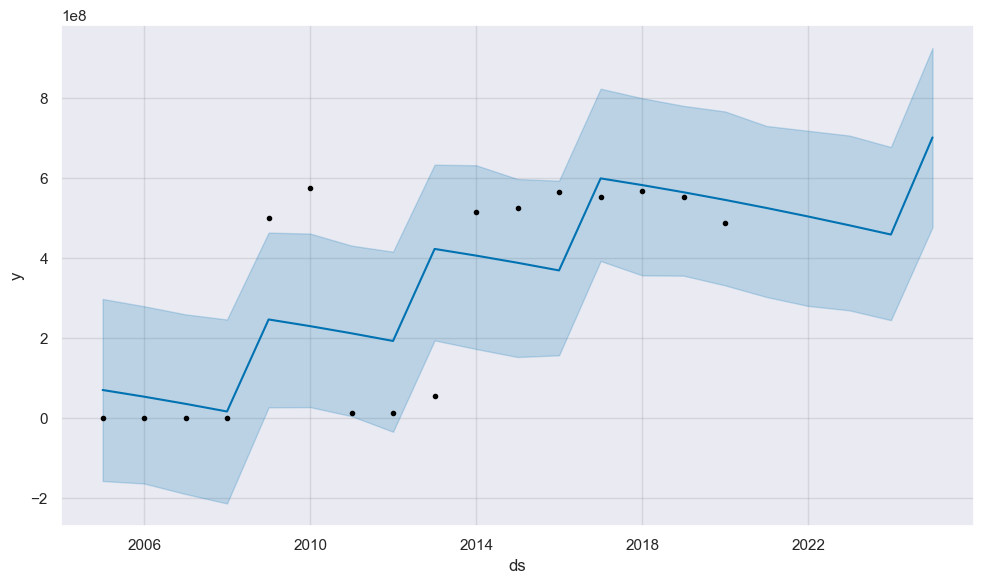

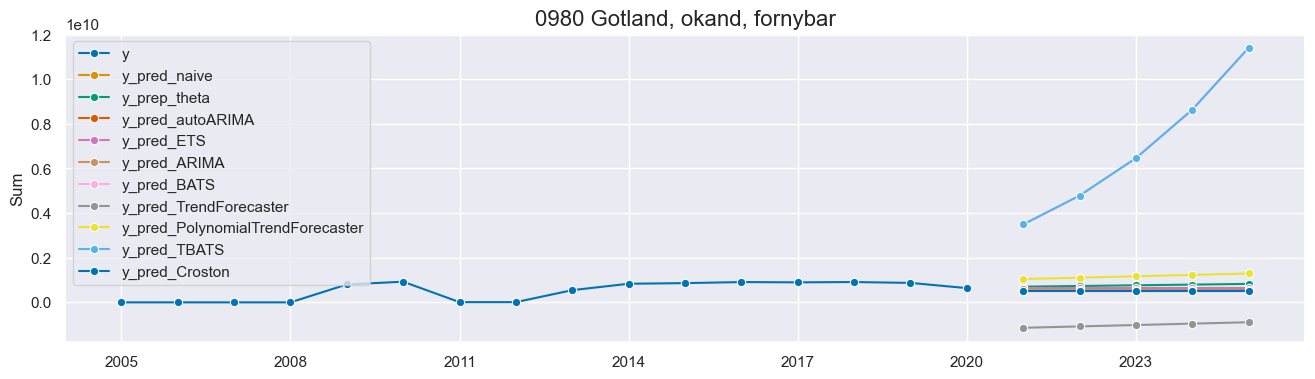

16:04:13 - cmdstanpy - INFO - Chain [1] start processing
16:04:13 - cmdstanpy - INFO - Chain [1] done processing


1480 G�teborg
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



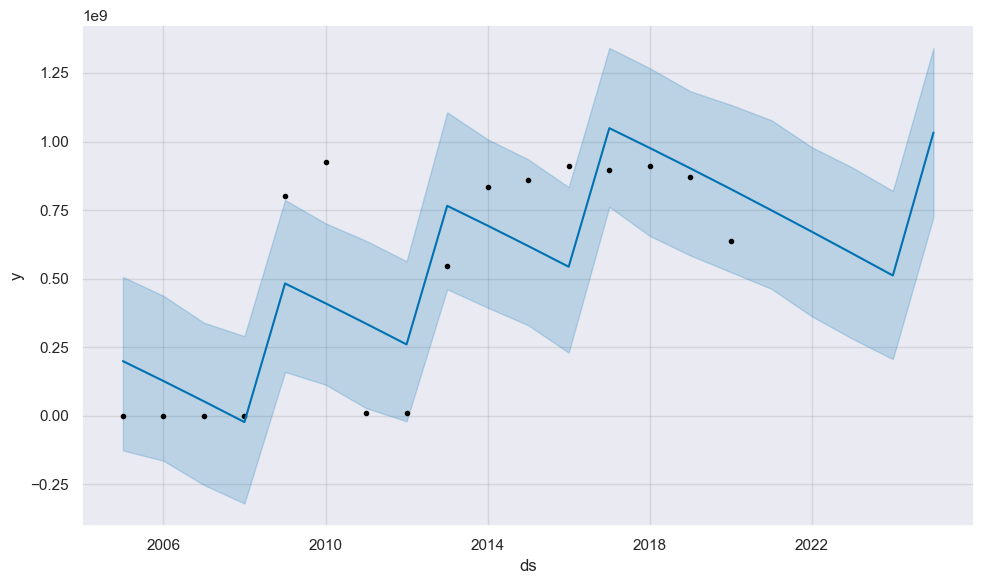

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



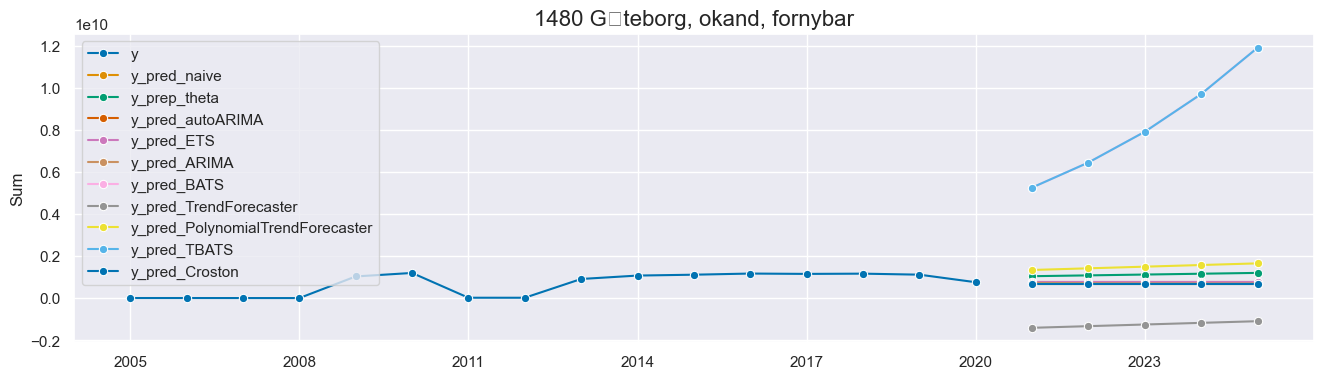

16:04:51 - cmdstanpy - INFO - Chain [1] start processing
16:04:51 - cmdstanpy - INFO - Chain [1] done processing


22 V�sternorrlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



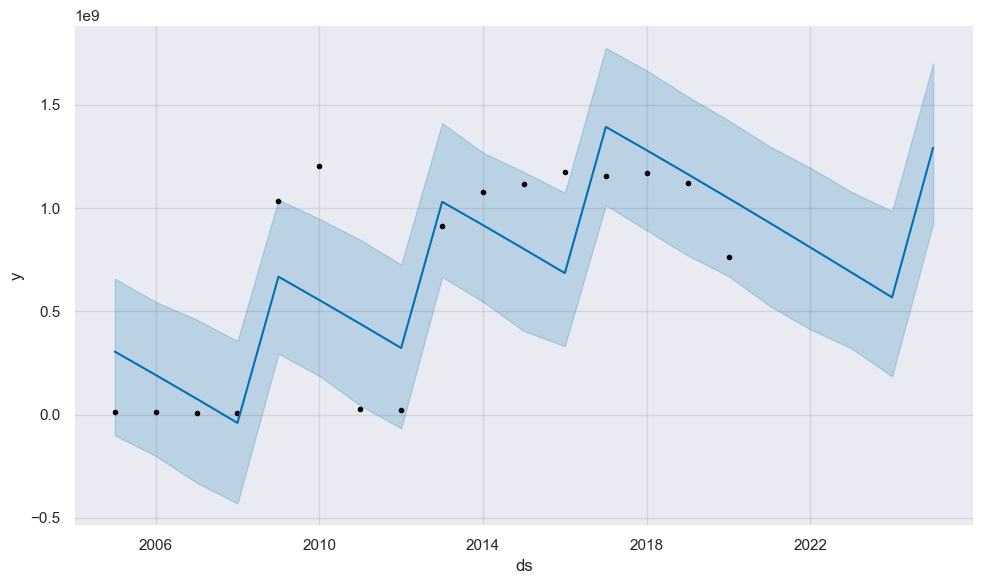

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



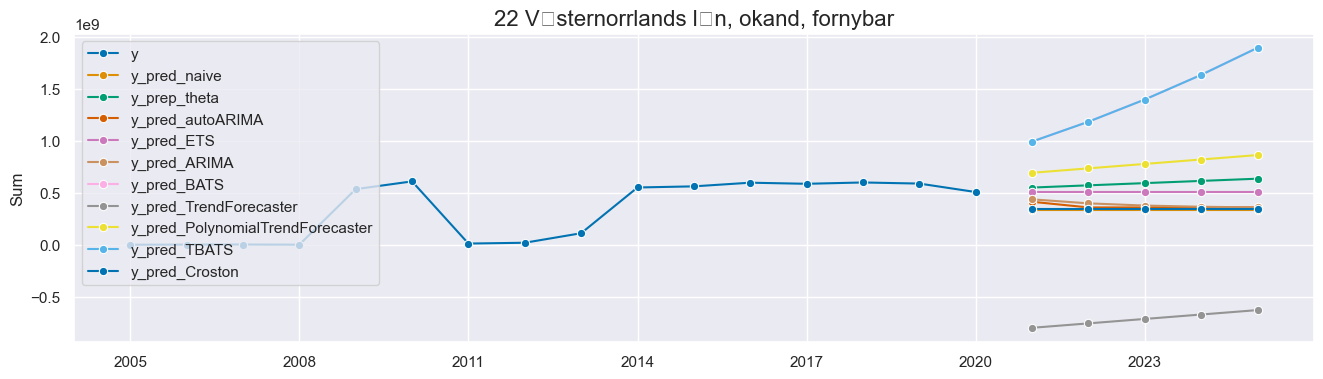

16:05:15 - cmdstanpy - INFO - Chain [1] start processing
16:05:15 - cmdstanpy - INFO - Chain [1] done processing


2581 Pite�
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



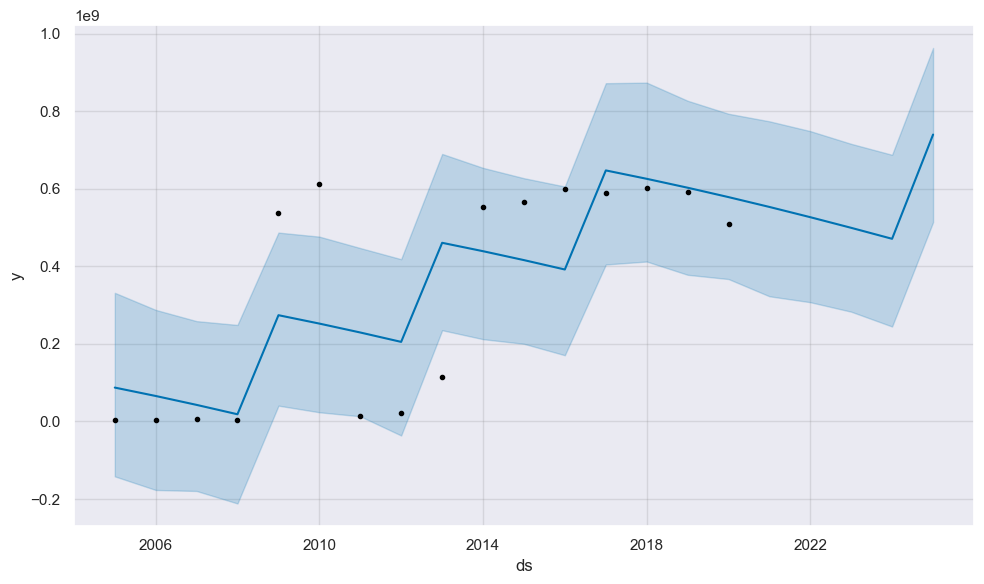

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



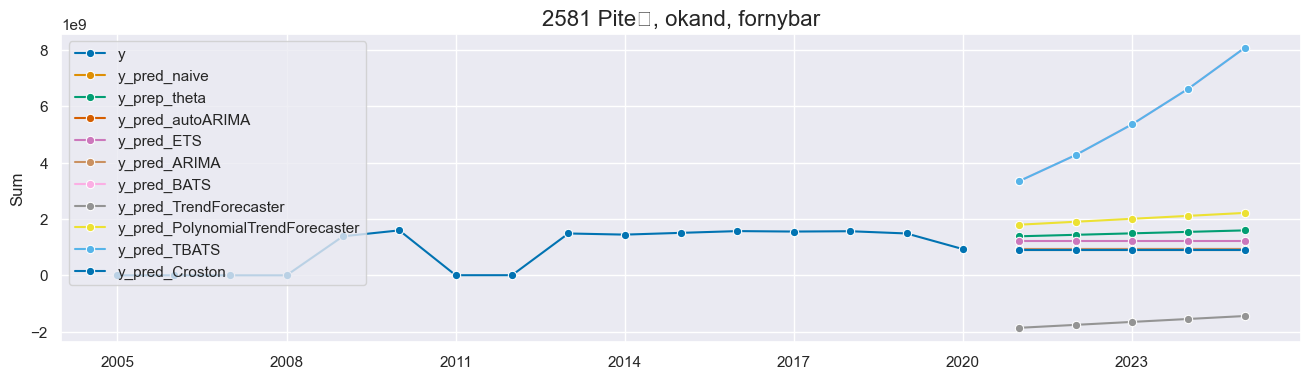

16:06:02 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing


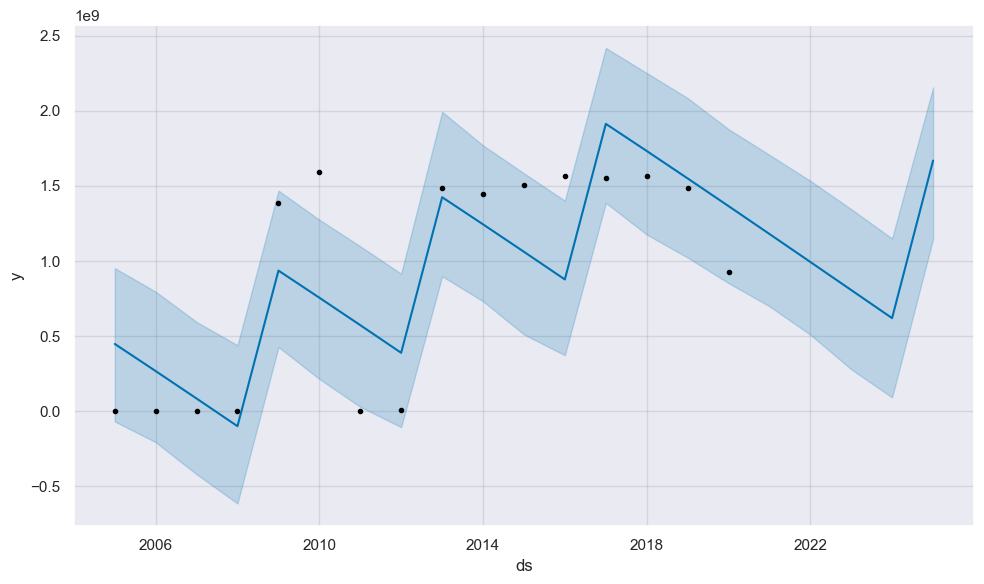

In [97]:
# fjarrvarmeproduktion
for region in fjarrvarmeproduktion.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = fjarrvarmeproduktion[fjarrvarmeproduktion.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(fornybar_produktionssatt)
                
                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS().fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA().fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS().fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # Instantiate PolynomialTrendForecaster
                forecaster = PolynomialTrendForecaster().fit(y)
                # Predict PolynomialTrendForecaster 
                y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS().fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, y_pred_theta, y_pred_autoARIMA, y_pred_ETS, y_pred_ARIMA, y_pred_BATS, y_pred_TrendForecaster, y_pred_PolynomialTrendForecaster, y_pred_TBATS, y_pred_Croston, 
                                    labels=["y", "y_pred_naive", "y_prep_theta", "y_pred_autoARIMA", "y_pred_ETS", "y_pred_ARIMA", "y_pred_BATS", "y_pred_TrendForecaster", "y_pred_PolynomialTrendForecaster", "y_pred_TBATS", "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, fornybar_produktionssatt), fontsize=16)
                plt.show(fig)            
                
                # # Prophet
                data['ds'] = data.index.to_timestamp()
                data['y'] = data.Sum
                m = Prophet(
                    yearly_seasonality=True,)
                m.fit(data)
                future = m.make_future_dataframe(
                    periods=5, 
                    freq='Y',
                    )
                forecast = m.predict(future)
                fig1 = m.plot(forecast)
                plot_plotly(m, forecast)

                # print("----------------")   

            # else:
            #     print("----------------")   


00 Riket
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



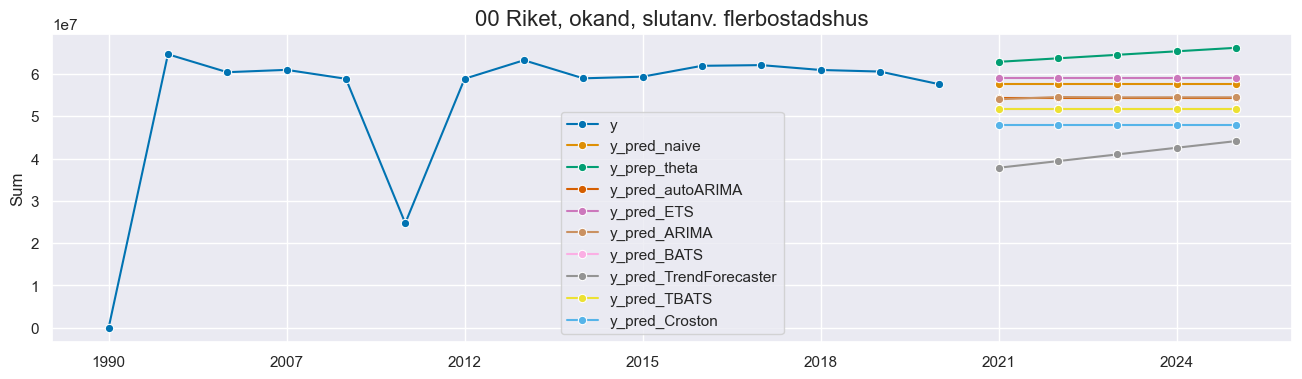

16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing


01 Stockholms l�n
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



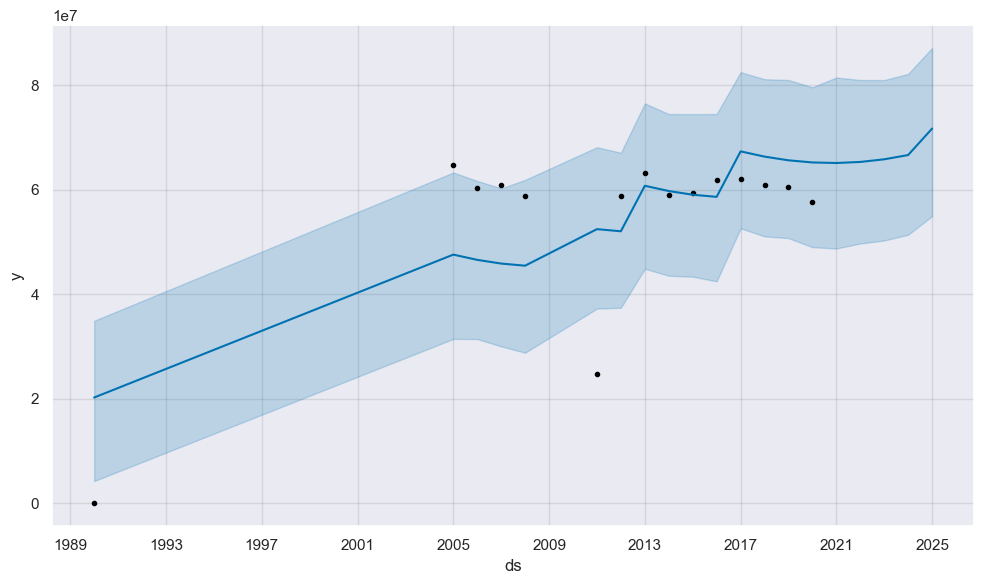

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



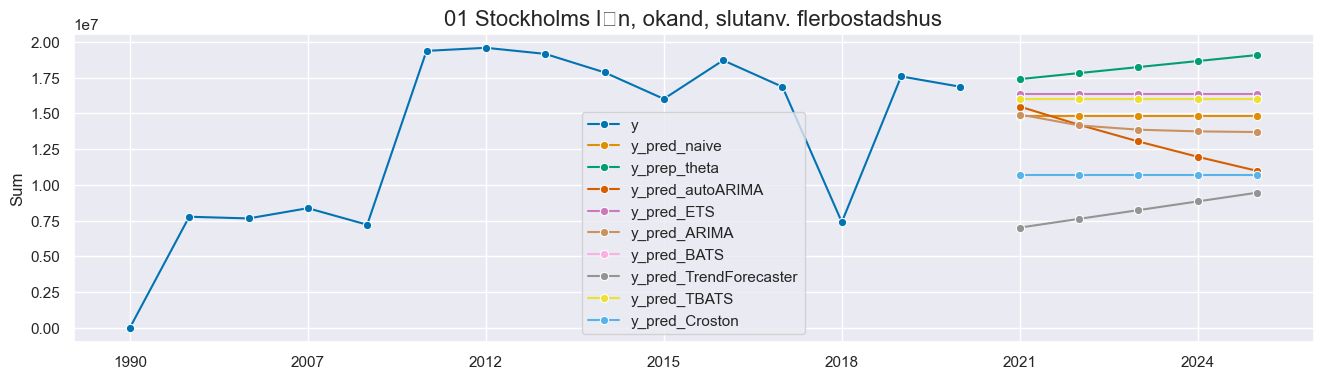

16:09:47 - cmdstanpy - INFO - Chain [1] start processing
16:09:47 - cmdstanpy - INFO - Chain [1] done processing


0117 �ster�ker
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



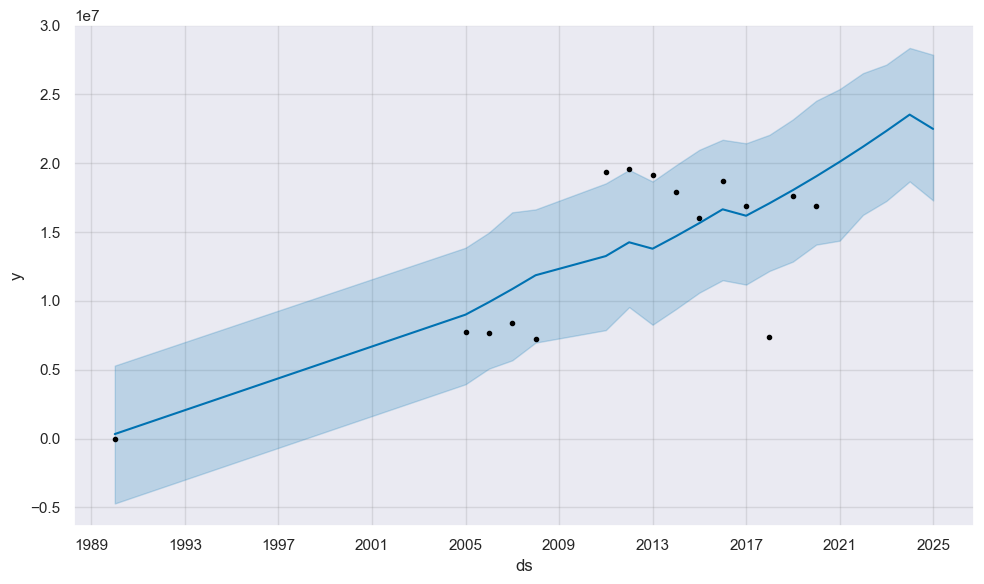

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



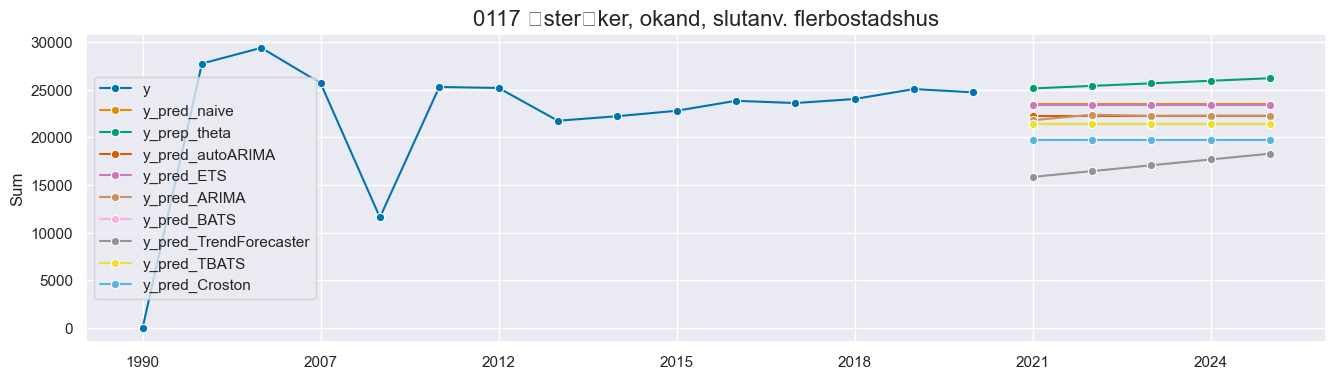

16:09:55 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing


0160 T�by
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



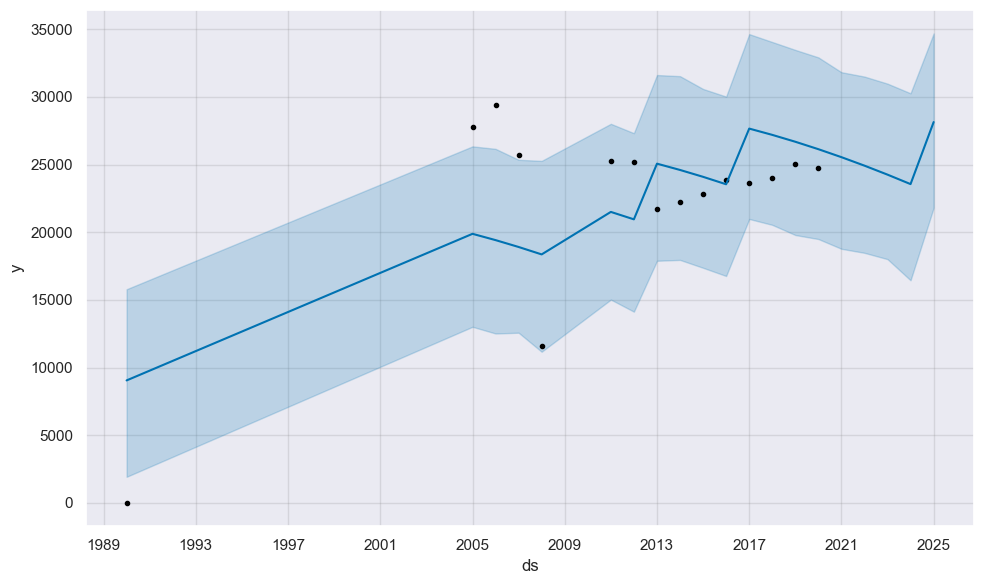

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



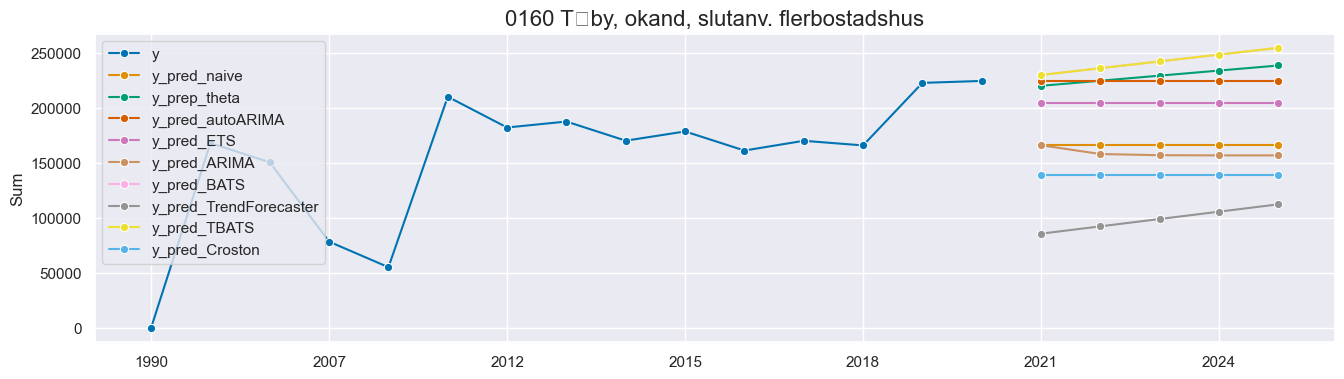

16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing


0180 Stockholm
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



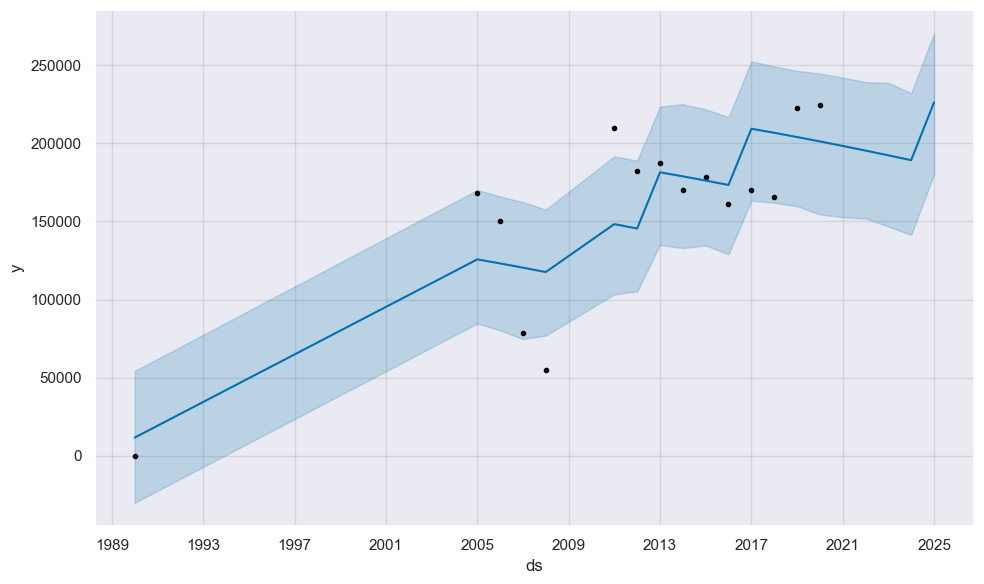

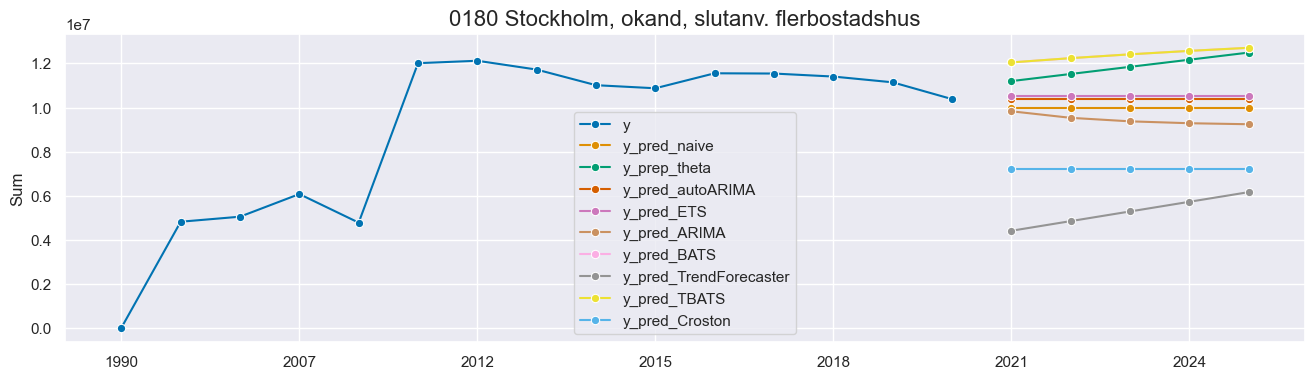

16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing


09 Gotlands l�n
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



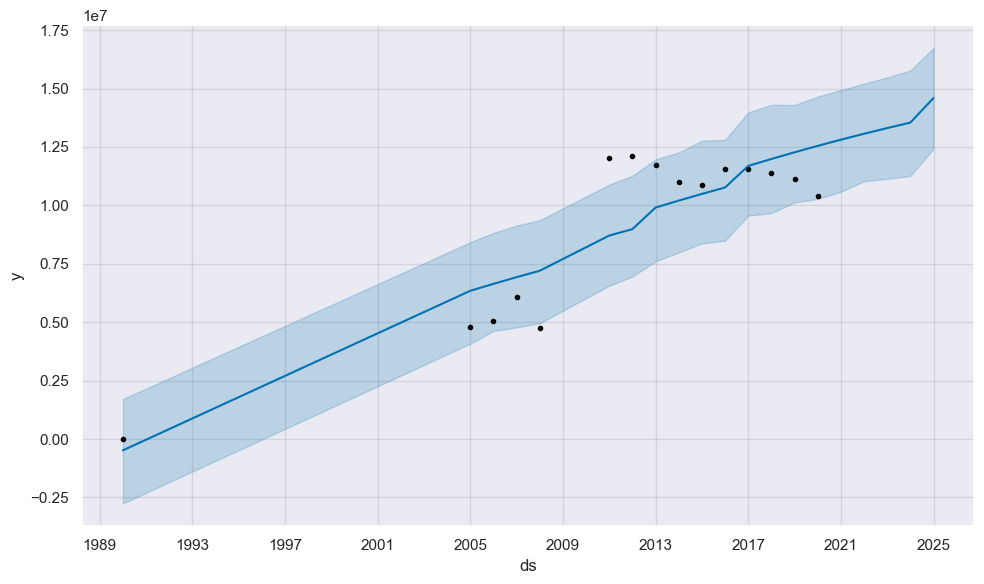

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



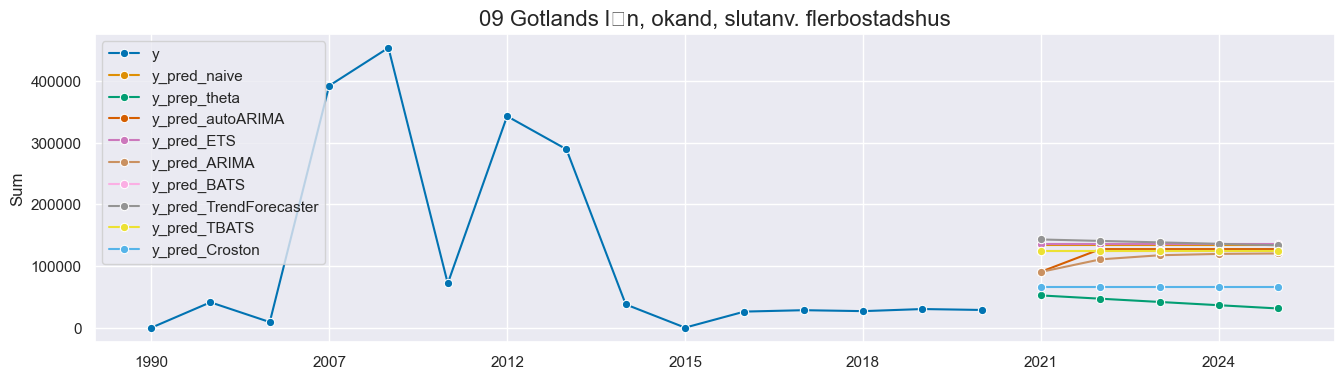

16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing


0980 Gotland
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



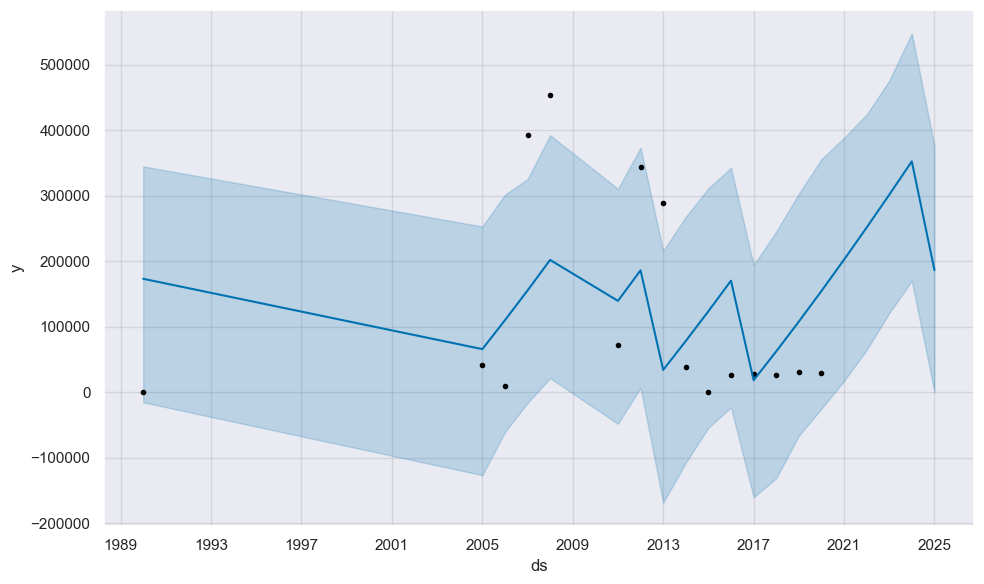

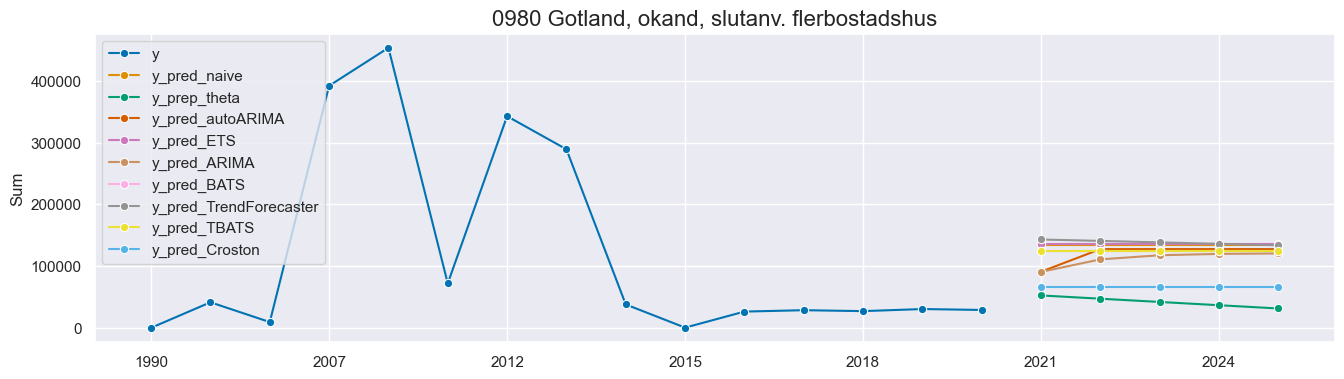

16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:34 - cmdstanpy - INFO - Chain [1] done processing


1480 G�teborg
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



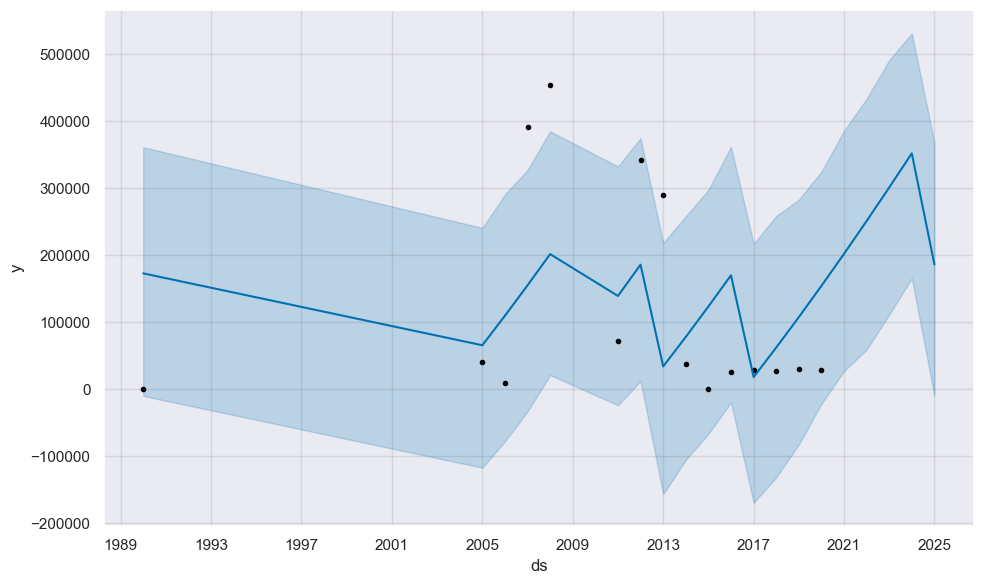

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



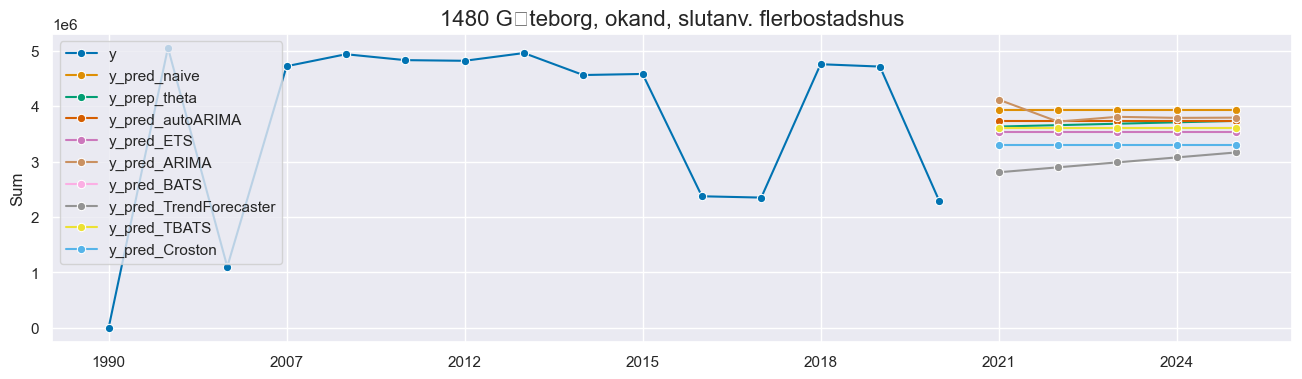

16:10:40 - cmdstanpy - INFO - Chain [1] start processing
16:10:40 - cmdstanpy - INFO - Chain [1] done processing


22 V�sternorrlands l�n
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



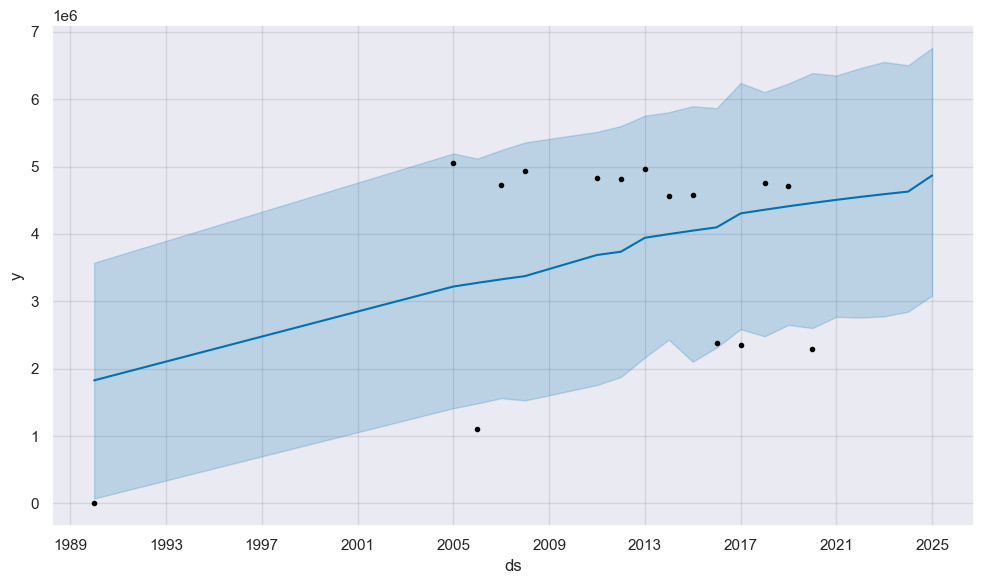

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



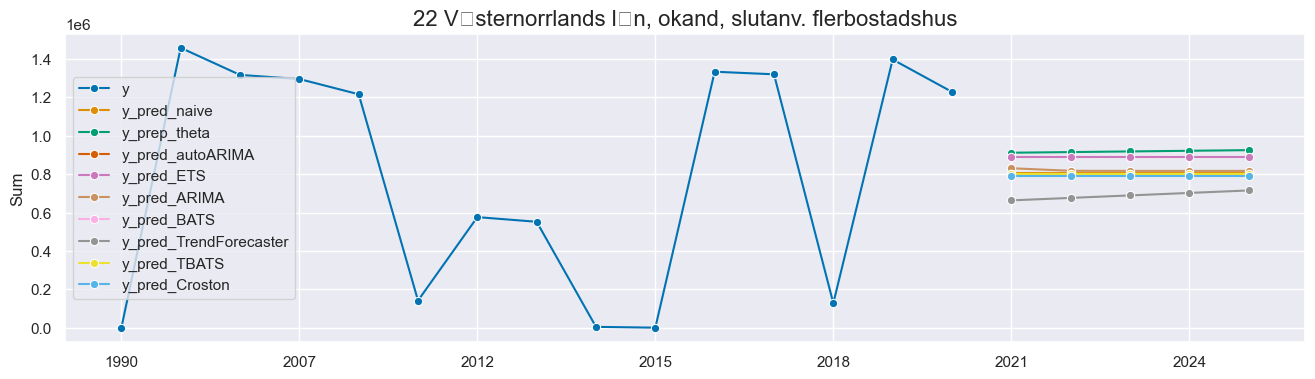

16:10:49 - cmdstanpy - INFO - Chain [1] start processing
16:10:49 - cmdstanpy - INFO - Chain [1] done processing


2581 Pite�
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



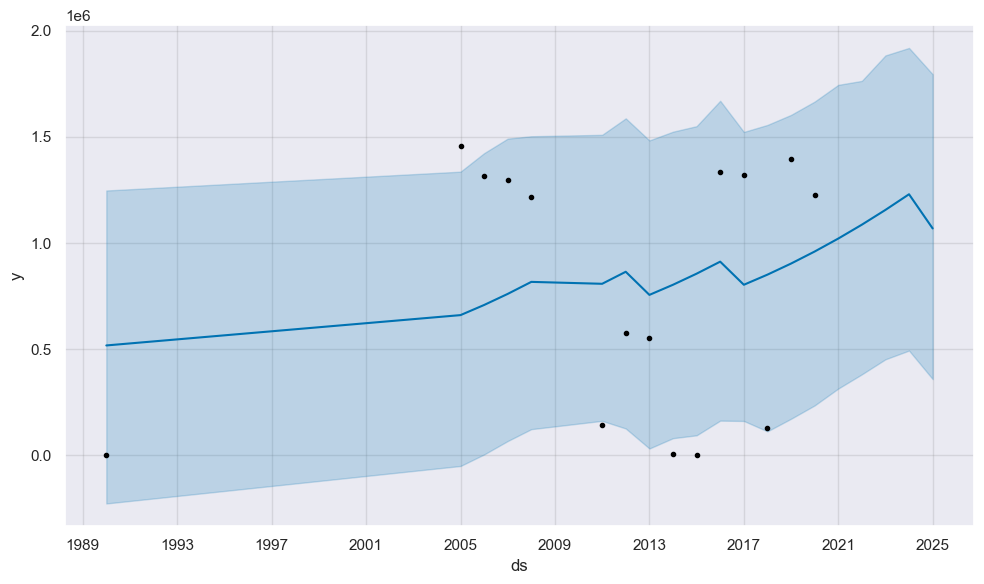

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



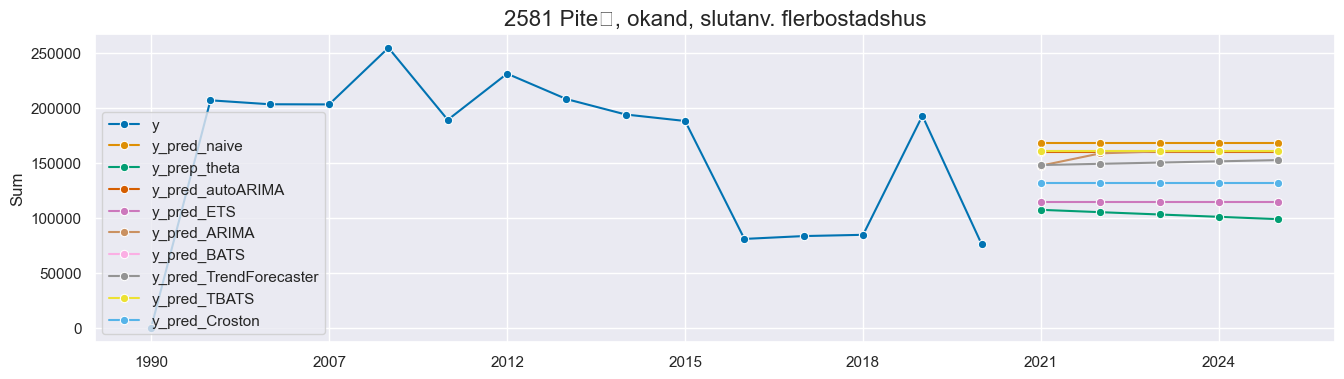

16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing


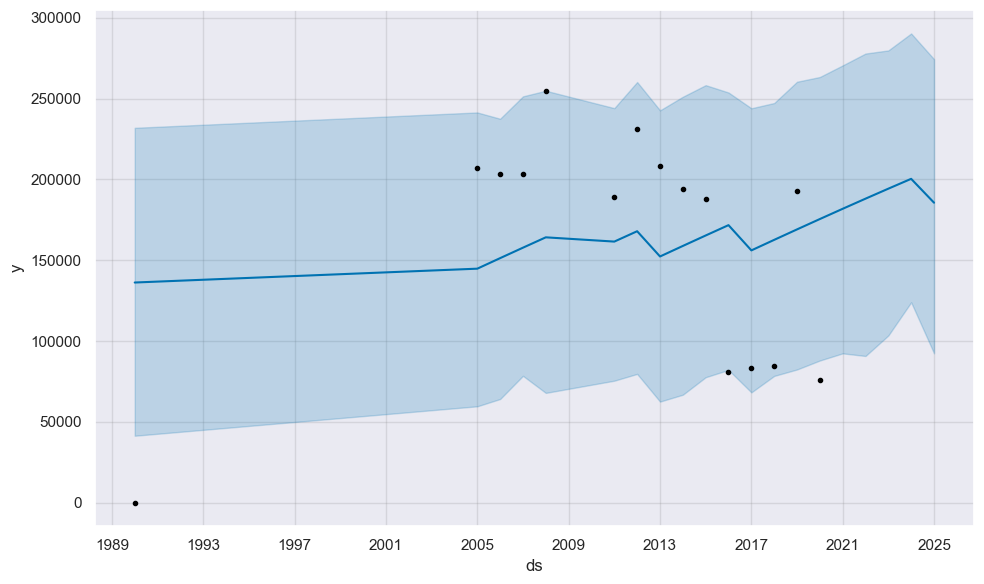

In [101]:
# slutanvandning
for region in slutanvandning.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = slutanvandning[slutanvandning.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for forbrukarkategori in data.forbrukarkategori.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.forbrukarkategori == forbrukarkategori].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(forbrukarkategori)

                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS().fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA().fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS().fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # # Instantiate PolynomialTrendForecaster
                # forecaster = PolynomialTrendForecaster().fit(y)
                # # Predict PolynomialTrendForecaster 
                # y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS().fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred,
                        y_pred_theta, 
                        y_pred_autoARIMA, 
                        y_pred_ETS, 
                        y_pred_ARIMA, 
                        y_pred_BATS, 
                        y_pred_TrendForecaster, 
                        # y_pred_PolynomialTrendForecaster, 
                        y_pred_TBATS, 
                        y_pred_Croston, 
                        labels=["y", "y_pred_naive", 
                        "y_prep_theta", 
                        "y_pred_autoARIMA", 
                        "y_pred_ETS", 
                        "y_pred_ARIMA", 
                        "y_pred_BATS", 
                        "y_pred_TrendForecaster", 
                        # "y_pred_PolynomialTrendForecaster", 
                        "y_pred_TBATS", 
                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, forbrukarkategori), fontsize=16)
                plt.show(fig)            
                
                # # Prophet
                data['ds'] = data.index.to_timestamp()
                data['y'] = data.Sum
                m = Prophet(
                    yearly_seasonality=True,)
                m.fit(data)
                future = m.make_future_dataframe(
                    periods=5, 
                    freq='Y',
                    )
                forecast = m.predict(future)
                fig1 = m.plot(forecast)
                plot_plotly(m, forecast)

                # print("----------------")   

            # else:
            #     print("----------------")   


fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



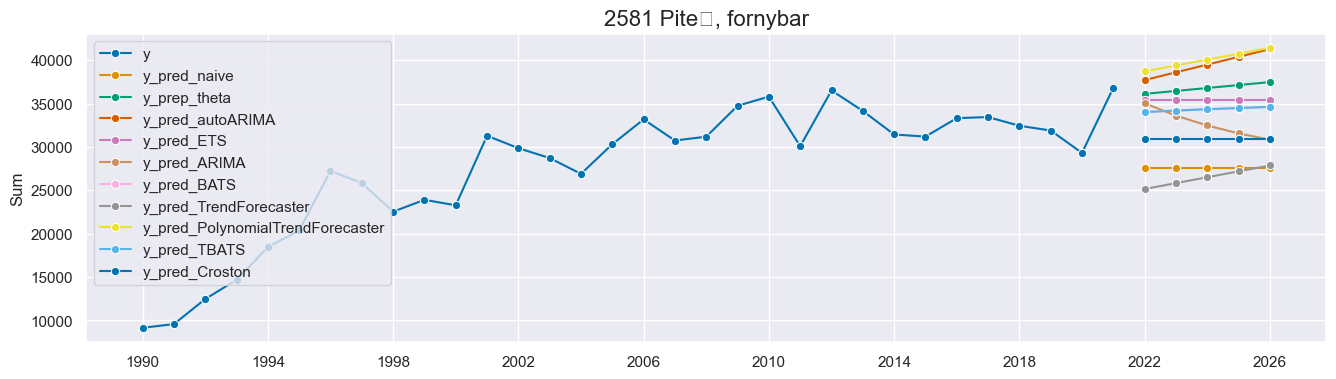

16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:43 - cmdstanpy - INFO - Chain [1] done processing


icke-fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



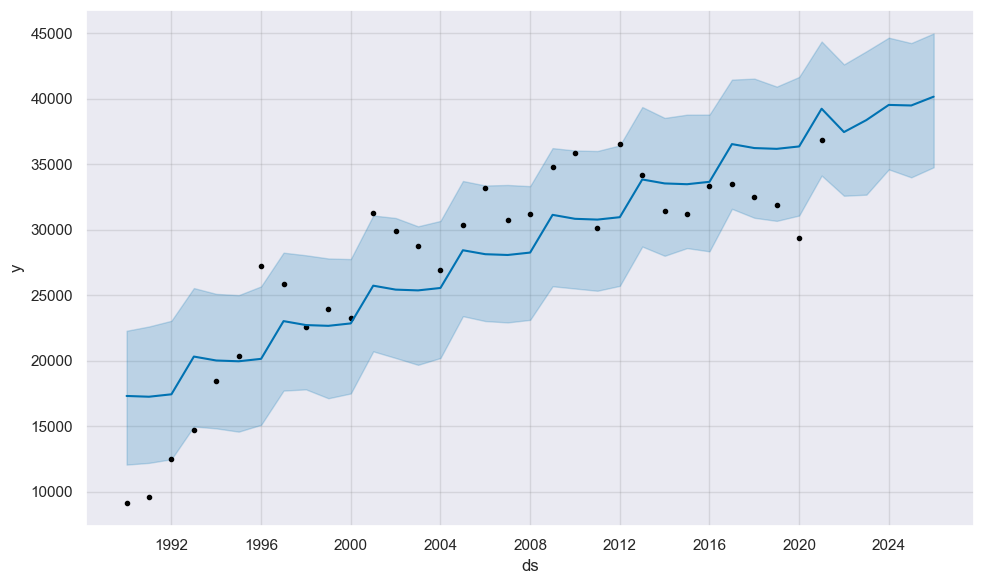

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



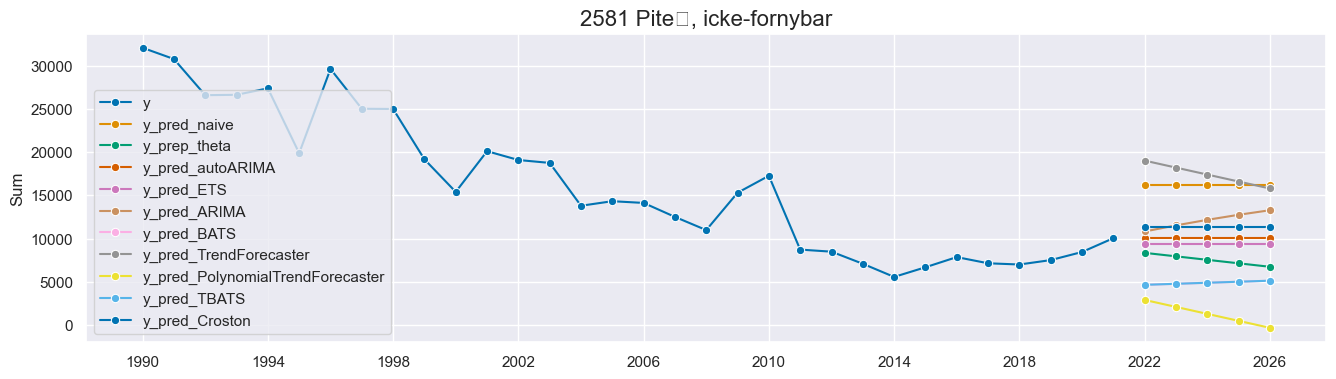

16:13:58 - cmdstanpy - INFO - Chain [1] start processing
16:13:58 - cmdstanpy - INFO - Chain [1] done processing


okand
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



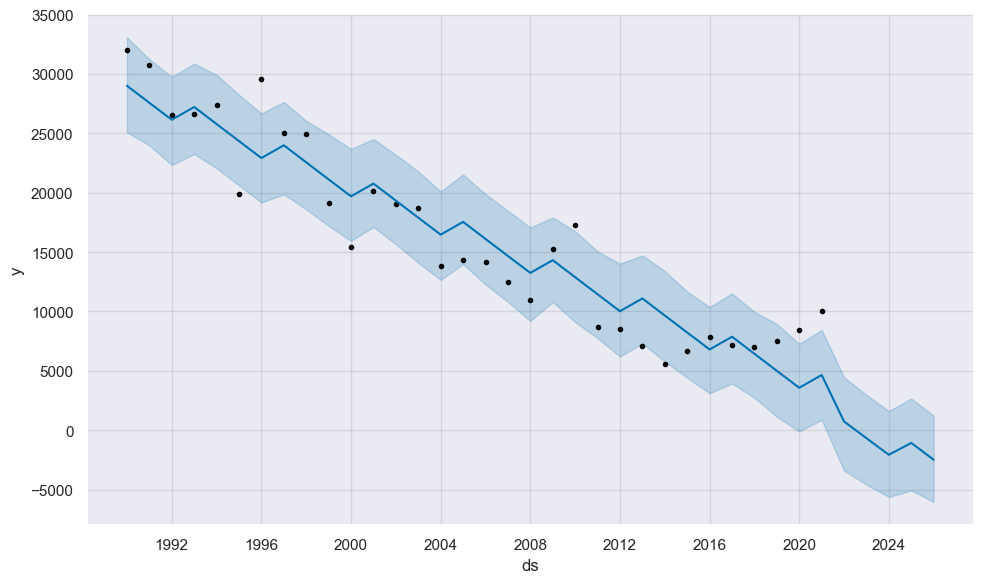

C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.



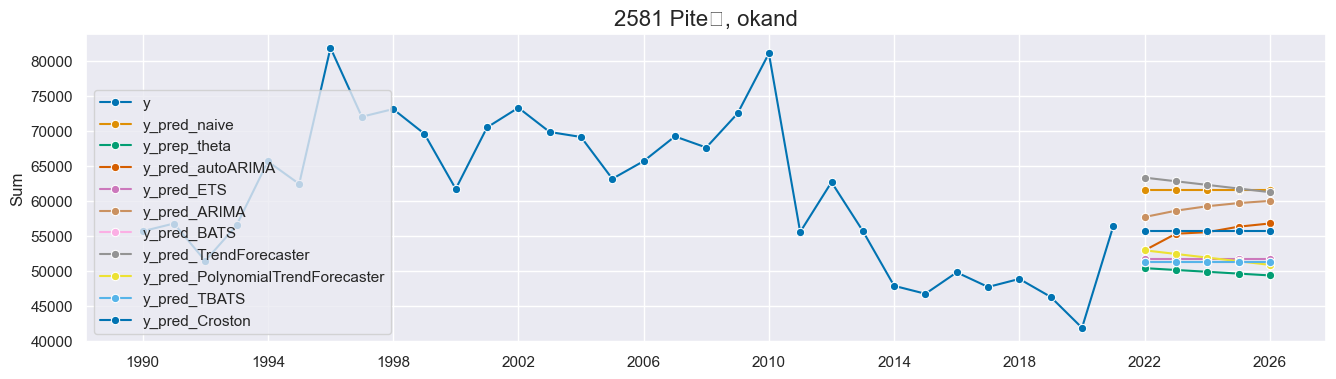

16:14:14 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing


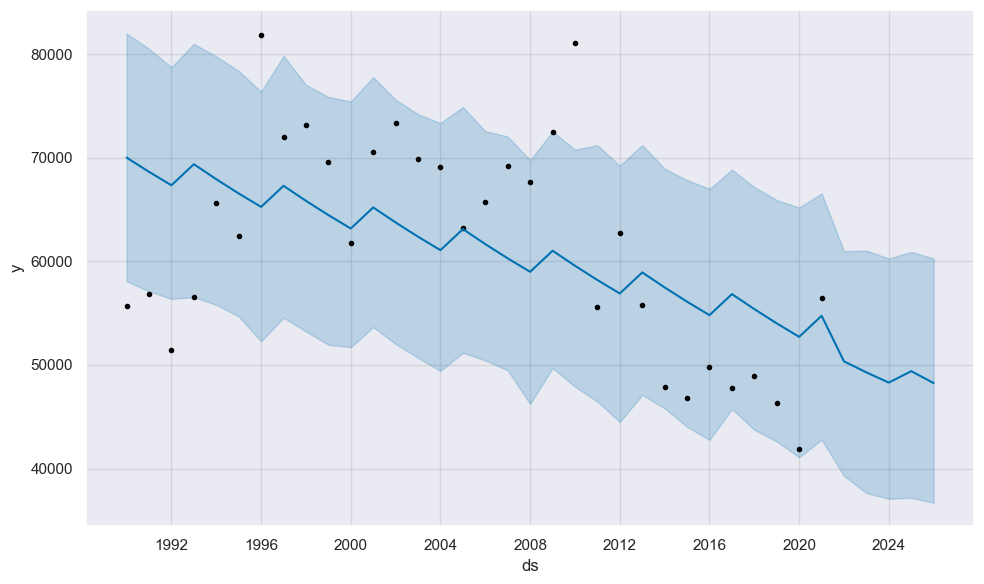

In [103]:
# bransleforbrukning


for fornybar_bransletyp in bransleforbrukning.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
    data = bransleforbrukning[bransleforbrukning.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)    
    for produktionsslag in data.produktionsslag.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.produktionsslag == produktionsslag].reset_index(drop=True)
        if not data.empty:
            print(fornybar_bransletyp)
            print(produktionsslag)
            
            
            data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
            data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

            y = data[['Sum']].squeeze()

            # create forecasting horizon
            fh = ForecastingHorizon(
                    pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
            )
            
            # Instantiate NaiveForecaster:
            forecaster = NaiveForecaster(strategy='mean').fit(y)
            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Instantiate Theta:
            forecaster = ThetaForecaster(deseasonalize=False).fit(y)
            # Predict Theta:
            y_pred_theta = forecaster.predict(fh=fh)
            
            # Instantiate autoARIMA
            forecaster = AutoARIMA(seasonal=False).fit(y)
            # Predict autoARIMA 
            y_pred_autoARIMA = forecaster.predict(fh)

            # Instantiate AutoETS
            forecaster = AutoETS().fit(y)
            # Predict AutoETS 
            y_pred_ETS = forecaster.predict(fh)

            # Instantiate ARIMA
            forecaster = ARIMA().fit(y)
            # Predict ARIMA 
            y_pred_ARIMA = forecaster.predict(fh)

            # Instantiate BATS
            forecaster = BATS().fit(y)
            # Predict BATS 
            y_pred_BATS = forecaster.predict(fh)

            # Instantiate TrendForecaster
            forecaster = TrendForecaster().fit(y)
            # Predict TrendForecaster 
            y_pred_TrendForecaster = forecaster.predict(fh)

            # Instantiate PolynomialTrendForecaster
            forecaster = PolynomialTrendForecaster().fit(y)
            # Predict PolynomialTrendForecaster 
            y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
            
            # Instantiate TBATS
            forecaster = TBATS().fit(y)
            # Predict TBATS 
            y_pred_TBATS = forecaster.predict(fh)
            
            # Instantiate Croston
            forecaster = Croston().fit(y)
            # Predict Croston 
            y_pred_Croston = forecaster.predict(fh)
            
            # Check it out:
            fig = plot_series(y, y_pred, y_pred_theta, y_pred_autoARIMA, y_pred_ETS, y_pred_ARIMA, y_pred_BATS, y_pred_TrendForecaster, y_pred_PolynomialTrendForecaster, y_pred_TBATS, y_pred_Croston, 
                                labels=["y", "y_pred_naive", "y_prep_theta", "y_pred_autoARIMA", "y_pred_ETS", "y_pred_ARIMA", "y_pred_BATS", "y_pred_TrendForecaster", "y_pred_PolynomialTrendForecaster", "y_pred_TBATS", "y_pred_Croston"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig) 
            
            # # Prophet
            data['ds'] = data.index.to_timestamp()
            data['y'] = data.Sum
            m = Prophet(
                yearly_seasonality=True,)
            m.fit(data)
            future = m.make_future_dataframe(
                periods=5, 
                freq='Y',
                )
            forecast = m.predict(future)
            fig1 = m.plot(forecast)
            plot_plotly(m, forecast)

            # print("----------------")   

        # else:
        #     print("----------------")   


00 Riket
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\ProgramData\Anaconda3\envs\thisone\li

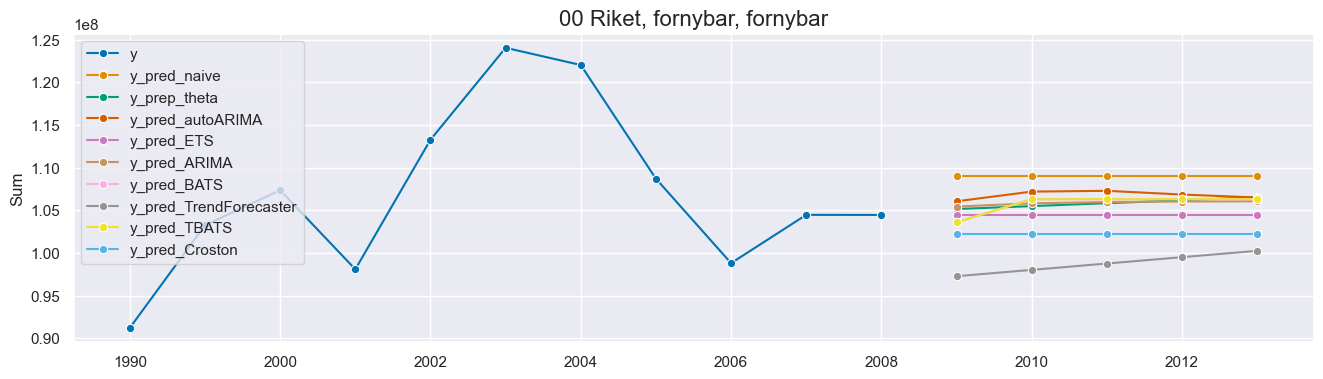

16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing


01 Stockholms l�n
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [106]:
# energidata

for region in energidata.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = energidata[energidata.region == region].reset_index(drop=True)    
    for fornybar_energityp in data.fornybar_energityp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_energityp == fornybar_energityp].reset_index(drop=True)
        for fornybar_kategori in data.fornybar_kategori.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_kategori == fornybar_kategori].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_energityp)
                print(fornybar_kategori)

                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS().fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA().fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS().fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # # Instantiate PolynomialTrendForecaster
                # forecaster = PolynomialTrendForecaster().fit(y)
                # # Predict PolynomialTrendForecaster 
                # y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS().fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, 
                        y_pred_theta, 
                        y_pred_autoARIMA, 
                        y_pred_ETS, 
                        y_pred_ARIMA, 
                        y_pred_BATS, 
                        y_pred_TrendForecaster, 
                        # y_pred_PolynomialTrendForecaster, 
                        y_pred_TBATS, 
                        y_pred_Croston, 
                        labels=["y", "y_pred_naive", 
                        "y_prep_theta", 
                        "y_pred_autoARIMA", 
                        "y_pred_ETS", 
                        "y_pred_ARIMA", 
                        "y_pred_BATS", 
                        "y_pred_TrendForecaster", 
                        # "y_pred_PolynomialTrendForecaster", 
                        "y_pred_TBATS", 
                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_energityp, fornybar_kategori), fontsize=16)
                plt.show(fig)            
                
                # # Prophet
                data['ds'] = data.index.to_timestamp()
                data['y'] = data.Sum
                m = Prophet(
                    yearly_seasonality=True,)
                m.fit(data)
                future = m.make_future_dataframe(
                    periods=5, 
                    freq='Y',
                    )
                forecast = m.predict(future)
                fig1 = m.plot(forecast)
                plot_plotly(m, forecast)

                # print("----------------")   

            # else:
            #     print("----------------")   
